# Large Sample Comparison Results

In this section we compare the different distribution estimation methods on a large sample of data and view the results from a wide range of evaluation metrics.  The methods are compared by plotting cumulative distribution functions (CDFs) to visualize the behaviour across the full sample, since in estimation in ungauged basins it is important to understand the range of outcomes more broadly.  The evaluation metrics include RMSE, RE, NSE, KGE, KLD, and EMD, and these have different emphasis on the underlying distribution characteristics.  


In [1]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import xarray as xr

import json
from multiprocessing import Pool

import geopandas as gpd
from shapely.geometry import Point
import xyzservices.providers as xyz
from scipy.stats import linregress

from bokeh.plotting import figure, show, output_file, save
from bokeh.layouts import gridplot, row, column, layout
from bokeh.transform import factor_cmap, linear_cmap
from bokeh.models.formatters import CustomJSTickFormatter

from bokeh.models import ColumnDataSource, LinearAxis, Range1d, HoverTool, Div
from bokeh.io import output_notebook
from bokeh.palettes import Sunset10, Vibrant7, Category20, Bokeh6, Bokeh7, Bokeh8, Greys256, Blues256

from bokeh.models import ColumnDataSource, LinearColorMapper, ColorBar, PrintfTickFormatter, FixedTicker
from bokeh.plotting import figure, show
from bokeh.transform import transform
from bokeh.palettes import RdBu

from bokeh.plotting import figure
from sklearn.linear_model import QuantileRegressor
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import MultipleLocator, LogLocator, NullFormatter, SymmetricalLogLocator, FormatStrFormatter



from shapely.geometry import Point

from utils.kde_estimator import KDEEstimator
from utils.fdc_estimator_context import FDCEstimationContext
from utils.fdc_data import StationData
from utils.evaluation_metrics import EvaluationMetrics

import utils.data_processing_functions as dpf

import xyzservices.providers as xyz
tiles = xyz['USGS']['USTopo']

output_notebook()

Loading BokehJS ...

In [2]:
attr_fpath = 'data/catchment_attributes_with_runoff_stats.csv'
attr_df = pd.read_csv(attr_fpath, dtype={'Official_ID': str})
station_ids = sorted(attr_df['official_id'].unique().tolist())

# streamflow folder from (updated) HYSETS
HYSETS_DIR = Path('/home/danbot/code/common_data/HYSETS')
hs_df = pd.read_csv('data/HYSETS_watershed_properties.txt', sep=';')
hs_df = hs_df[hs_df['Official_ID'].isin(station_ids)]
hs_df.head(2)

,Watershed_ID,Source,Name,Official_ID,Centroid_Lat_deg_N,Centroid_Lon_deg_E,Drainage_Area_km2,Drainage_Area_GSIM_km2,Flag_GSIM_boundaries,Flag_Artificial_Boundaries,...,Land_Use_Wetland_frac,Land_Use_Water_frac,Land_Use_Urban_frac,Land_Use_Shrubs_frac,Land_Use_Crops_frac,Land_Use_Snow_Ice_frac,Flag_Land_Use_Extraction,Permeability_logk_m2,Porosity_frac,Flag_Subsoil_Extraction
846,847,HYDAT,CROWSNEST RIVER AT FRANK,05AA008,49.59732,-114.4106,402.6522,NaN,0,0,...,0.0103,0.0065,0.0328,0.0785,0.0015,0.0002,1,-15.543306,0.170479,1
849,850,HYDAT,CASTLE RIVER NEAR BEAVER MINES,05AA022,49.48866,-114.1444,820.6510,NaN,0,0,...,0.0058,0.0023,0.0105,0.1156,0.0246,0.0000,1,-15.929747,0.150196,1


In [3]:
watershed_id_dict = {row['Watershed_ID']: row['Official_ID'] for _, row in hs_df.iterrows()}
# and the inverse
official_id_dict = {row['Official_ID']: row['Watershed_ID'] for _, row in hs_df.iterrows()}
# also for drainage areas
da_dict = {row['Official_ID']: row['Drainage_Area_km2'] for _, row in hs_df.iterrows()}

In [4]:
# retrieve LSTM ensemble predictions
LSTM_ensemble_result_folder = '/home/danbot/code/neuralhydrology/data/ensemble_results_20250514'# uses NSE mean as loss function
# LSTM_ensemble_result_folder = '/home/danbot/code/neuralhydrology/data/ensemble_results_20250627'# uses NSE 95% as loss function
lstm_result_files = os.listdir(LSTM_ensemble_result_folder)
lstm_result_stns = [e.split('_')[0] for e in lstm_result_files]

# filter for the common stations between BCUB region and LSTM-compatible (i.e. 1980-)
daymet_concurrent_stations = list(set(station_ids) & set(lstm_result_stns))
# assert '012414900' in daymet_concurrent_stations
print(f'There are {len(daymet_concurrent_stations)} monitored basins concurrent with LSTM ensemble results.')


There are 723 monitored basins concurrent with LSTM ensemble results.


In [5]:
def load_and_filter_hysets_data(station_ids, hs_df):
    hs_df = hs_df[hs_df['Official_ID'].isin(station_ids)]

    # load the updated HYSETS data
    updated_filename = 'HYSETS_2023_update_QC_stations.nc'
    ds = xr.open_dataset(HYSETS_DIR / updated_filename)

    # Get valid IDs as a NumPy array
    selected_ids = hs_df['Watershed_ID'].values

    # Get boolean index where watershedID in selected_set
    # safely access watershedID as a variable first
    ws_ids = ds['watershedID'].data  # or .values if you prefer
    mask = np.isin(ws_ids, selected_ids)

    # Apply mask to data
    ds = ds.sel(watershed=mask)
    # Step 1: Promote 'watershedID' to a coordinate on the 'watershed' dimension
    ds = ds.assign_coords(watershedID=("watershed", ds["watershedID"].data))

    # Step 2: Set 'watershedID' as the index for the 'watershed' dimension
    return ds.set_index(watershed="watershedID")

ds = load_and_filter_hysets_data(station_ids, hs_df)

In [6]:
def retrieve_timeseries_discharge(stn, ds):
    watershed_id = official_id_dict[stn]
    # drainage_area = self.ctx.da_dict[stn]
    # data = self.ctx.data
    df = ds['discharge'].sel(watershed=str(watershed_id)).to_dataframe(name='discharge').reset_index()
    df = df.set_index('time')[['discharge']]
    df['zero_flow_flag'] = df['discharge'] == 0
    df.dropna(inplace=True)
    # clip minimum flow to 1e-4
    df['discharge'] = np.clip(df['discharge'], 1e-4, None)
    df.rename(columns={'discharge': stn}, inplace=True)
    df[f'{stn}_uar'] = 1000 * df[stn] / da_dict[stn]
    return df


def compare_results_and_input(stn, sim_df, ds):
    """Compare the input streamflow timeseries with the observed streamflow timeseries.
    Check that the dates in the output match the common dates between Daymet and the input data.
    """
    input_df = retrieve_timeseries_discharge(stn, ds)
    # clip the 'discharge' column to 1e-4, convert to unit area runoff (L/s/km2), and take the log
    input_df = input_df[input_df.index >= '1980-01-01']

    df = pd.concat([input_df, sim_df], axis=1, join='inner')
    df.dropna(inplace=True)

    df['streamflow_obs'] = np.exp(df['streamflow_obs'])
    sim_cols = [c for c in sim_df.columns if c.startswith('streamflow_sim')]
    df[sim_cols] = np.exp(df[sim_cols])
    # assert that the 'log_obs' and the 'streamflow_obs' columns are approximately equal

    # set tolerance in the order of 1 L/s/km2
    if not np.allclose(df[f'{stn}_uar'], df['streamflow_obs'], atol=1): 
        max_diff = np.abs(df[f'{stn}_uar'] - df['streamflow_obs']).max()
        print(f'Warning: {stn} has a max difference of {max_diff:.2f} between the input and output streamflow timeseries.')
        # find the dates around the max difference index
        # diff_index = np.abs(df['uar'] - df['streamflow_obs']).idxmax()
        # print(diff_index)
        # view 5 before and 5 after the max diff index
        # print(df.loc[diff_index - pd.Timedelta(days=5):diff_index + pd.Timedelta(days=5), ['uar', 'streamflow_obs']].head(10))
        
    return df

def process_lstm_station(args):
    stn, folder, ds = args
    try:
        fpath = os.path.join(folder, f'{stn}_ensemble.csv')
        df = pd.read_csv(fpath)
        df.rename(columns={'Unnamed: 0': 'time'}, inplace=True)
        df['time'] = pd.to_datetime(df['time'])
        df.set_index('time', inplace=True)
        result = compare_results_and_input(stn, df, ds)
        return stn, result
    except Exception as e:
        print(f"Failed to process {stn}: {e}")
        return stn, None

In [7]:
# retrieve LSTM ensemble predictions
# filter for the common stations
common_stations = list(set(station_ids) & set(lstm_result_stns))
print(f'There are {len(common_stations)} monitored basins with LSTM ensemble results.')
attr_df = attr_df[attr_df['official_id'].isin(common_stations)]

# args_list = [(stn, lstm_result_folder, ds) for stn in common_stations]

# with Pool() as pool:
#     lstm_results = dict(pool.map(process_lstm_station, args_list))

There are 723 monitored basins with LSTM ensemble results.


In [8]:
# load the predicted parameter results
target_cols = [
    'uar_mean_mean_predicted', 'uar_std_mean_predicted', 'uar_median_mean_predicted', 'uar_mad_mean_predicted',
    'log_uar_mean_mean_predicted', 'log_uar_std_mean_predicted', 'log_uar_median_mean_predicted', 'log_uar_mad_mean_predicted',
]

parameter_prediction_results_folder = 'data/results/parameter_prediction_results'
predicted_params_fpath   = os.path.join(parameter_prediction_results_folder, 'mean_parameter_predictions.csv')
stats = pd.read_csv(predicted_params_fpath, index_col=['official_id'], dtype={'official_id': str})
stats.head()
stats.columns = ['_'.join(c.split('_')) for c in stats.columns]
print(f' Loaded {len(stats)} stations with predicted parameters from {predicted_params_fpath}')    

 Loaded 1098 stations with predicted parameters from data/results/parameter_prediction_results/mean_parameter_predictions.csv


In [9]:
plots = []
m1s = ['log_uar_mean_actual', 'log_uar_std_actual']
m2s = ['log_uar_median_actual', 'log_uar_mad_actual']
for m1, s1 in [m1s, m2s]:
    p = figure(title=f'Observed {m1} vs. {s1} over (N={len(stats)})', width=600, height=350)
    slope, intercept, r_value, p_value, std_err = linregress(stats[m1], stats[s1])
    p.scatter(stats[m1], stats[s1], size=10, color='green', alpha=0.5, legend_label='Observed')
    x = np.linspace(stats[m1].min(), stats[m1].max(), 100)
    p.line(x, slope * x + intercept, color='red', legend_label=f'Y={slope:.2f}x + {intercept:.2f} (R²={r_value**2:.2f})', line_width=2)
    p.xaxis.axis_label = f'Log {m1.split('_')[2]} unit area runoff (L/s/km²)'
    p.yaxis.axis_label = f'Log {s1.split('_')[2]} of unit area runoff (L/s/km²)'
    # p.legend.location = 'top_left'
    p = dpf.format_fig_fonts(p,font_size=14)
    plots.append(p)
lt = column(plots)
# show(lt)

In [10]:
from scipy.spatial import cKDTree
from sklearn.preprocessing import StandardScaler

centroids = [Point(e['centroid_lon_deg_e'], e['centroid_lat_deg_n']) for e in attr_df.to_dict('records')]
pts_df = gpd.GeoDataFrame({'geometry': centroids}, crs='EPSG:4326')
pts_df.to_crs('EPSG:3005', inplace=True)

coords = np.array([[geom.x, geom.y] for geom in pts_df.geometry.centroid])
stn_tree = cKDTree(coords)

# Create mapping from official_id to index
id_to_index = {oid: i for i, oid in enumerate(attr_df["official_id"])}
index_to_id = {i: oid for oid, i in id_to_index.items()}  # Reverse mapping

# Extract values (excluding 'official_id' since it's categorical)
attribute_columns = ['log_drainage_area_km2', 'elevation_m', 'prcp', 'tmean', 'swe',
                     'centroid_lon_deg_e', 'centroid_lat_deg_n', 'land_use_forest_frac_2010', 
                    #  'land_use_snow_ice_frac_2010', 'land_use_wetland_frac_2010', 'land_use_water_frac_2010', 
                      ]
attr_df['tmean'] = (attr_df['tmin'] + attr_df['tmax']) / 2.0
# attr_gdf['log_drainage_area_km2'] = np.log(attr_df['drainage_area_km2'])

attr_values = attr_df[attribute_columns].to_numpy()
scaler = StandardScaler()
normalized_attr_values = scaler.fit_transform(attr_values)
# Convert normalized distances back to original units
std_devs_attrs = scaler.scale_  # Standard deviation of each feature
attr_tree = cKDTree(normalized_attr_values)

## Notes

### Nuance of "concurrent" kNN: k or not k?

When using kNN derived from sparse monitoring networks with inconsistent coverage, the "k" isn't exactly "k".  At the timestep level, addressing gaps in data yields different interpretations of k, where the simplest interpretation is that it represents the number of independent monitoring locations used to generate an ensemble simulation of an unmonitored location.  Werstuck and Coulibaly (2018) describe infilling data gaps with kNN, effectively a nested kNN, which appears most consistent with the "dynamic k" described below, but it is not the same, rather the infilled data are a temporal mean which suppresses the variability of the ensemble.  Below we describe several variants that address data gaps in kNN selection, and how they relate to the concept of k.:

* **Maximum k**:  The maximum number of stations that can be used to generate an ensemble simulation.  In the event of missing observations at one or more k, the effective number of stations is less k.  Overall, $k_\text{actual} \leq k$.  Given periods of concurrent gaps, the ensemble simulation could effectively be much lower than k, though it must be at least 1.
* **Strict k**: The number of stations used to generate an ensemble simulation is strictly k.  This method is related to the set-cover problem, where the goal is to select a subset of stations that maximizes the intersection of their data availability over a specified time period.  The problem is NP-hard and requires a greedy or approximate subset selection strategy when exhaustively testing all combinations becomes computationally infeasible.  I set a lenient minimum concurrent period (5 complete periods of 12 consecutive complete months (minimum 10 days per month)) to avoid expensive computation.  This is more truly "k-nearest", but it achieves this by searching further away in the network and ignoring potentially more relevant information if it is not concurrent with all records -- the higher the k, the greater chance of misalignment of records.
* **Effective k**:  The number of stations used to generate the ensemble simulation increases until average k observations per timestep.  In the event of missing observations at one or more k, more (less similar, more distant) stations must be incorporated to yield an average of k ensemble members per timestep.  Overall, $k_\text{actual} \geq k$.  This requires generating weights per timestep such that they sum to 1 where the set comprising k are not constant.
* **Dynamic k**: The number of stations overall to generate an ensemble simulation varies, but we guarantee that the number of stations used to generate the simulation is **k at each timestep**.  Here k is really fixed but the stations may vary across timesteps.

## Results

In [11]:
from utils.fdc_data import StationData
from utils.kde_estimator import KDEEstimator

results_dfs = {}
lstm_rev_date = LSTM_ensemble_result_folder.split('_')[-1]
sub_folder = f'lstm_{lstm_rev_date}' 
# results_folder = '/media/danbot/Samsung_T5/fdc_estimation_results/'
results_folder = 'data/results/fdc_estimation_results/'
completed_stns = [c.split('_')[0] for c in os.listdir(os.path.join(results_folder, 'parametric'))]
print(f'Found {len(set(completed_stns))} completed stations in {sub_folder} results folder.')

for method in ['parametric', 'lstm', 'knn']:
    print(f'   Loading {method} results')
    method_results_fpath = os.path.join('data', 'results', f'{method}_all_results.csv')
    if method == 'lstm':
        rev_date = LSTM_ensemble_result_folder.split('_')[-1]
        method_results_fpath = os.path.join('data', 'results', f'{method}_all_results_{rev_date}.csv')
    if os.path.exists(method_results_fpath):
        results_dfs[method] = pd.read_csv(method_results_fpath, dtype={'Official_ID': str})
        # results_dfs[method].rename({'TVB': 'PVB'}, axis=1, inplace=True)
    else:
        print(f'   {method} results not found in {method_results_fpath}, loading from individual station files...')
        res_folder = os.path.join(results_folder, method)
        if method == 'lstm':
            res_folder = os.path.join(results_folder, f'{method}_{rev_date}')
        args = [(stn, res_folder, method) for stn in completed_stns]

        with Pool() as pool:
            results_list = pool.map(dpf.load_results, args)

        merged = pd.concat(results_list, ignore_index=True)
        bad_dkl = merged[merged['KLD'].isna() | (merged['KLD'] < 0)].copy()
        if not bad_dkl.empty:
            print(f'Warning: {len(bad_dkl)} {method} rows with NaN or negative DKL values.')
            bad_stns = bad_dkl['Official_ID'].values
            raise Exception(f'Results have {len(bad_stns)} NaN or negative DKL values: {bad_stns}')
        method_results = pd.concat(results_list, ignore_index=True)
        # method_results.rename({'RB': 'MB', 'MRE': 'MRE'}, axis=1, inplace=True)
        results_dfs[method] = method_results
        print(f'   Loaded {int(len(results_dfs[method])/len(set(completed_stns)))} station results for {method} results')
        method_results.to_csv(method_results_fpath, index=False)


Found 719 completed stations in lstm_20250514 results folder.
   Loading parametric results
   Loading lstm results
   Loading knn results


In [12]:
for k, r in results_dfs.items():
    # take exponential to express as geometric mean / average multiplicative deviation
    results_dfs[k]['RMSE'] = 100 * (np.exp(results_dfs[k]['RMSE']) - 1)
    results_dfs[k]['RB'] = 100 * results_dfs[k]['RB']

In [13]:
# count the number of nan values in each column of results_dfs['parametric']
nan_counts = results_dfs['parametric'].isna().sum()
print("NaN counts in parametric results:")
print(nan_counts[nan_counts > 0])
# results_dfs['parametric'].head()


NaN counts in parametric results:
Series([], dtype: int64)


In [14]:
# add the unrestrained, 1950-present kNN results
# pre_1950_results_folder = 'data/fdc_estimation_results_1950/'
# results_list = parallel_load_fdc_estimation_results(completed_stns, pre_1950_results_folder, 'knn')
# results_dfs['knn_1950'] = pd.concat(results_list, ignore_index=True)

In [15]:
def split_knn_label_col(df):
    # Split the string column
    # Determine format based on length
    if 'MDB' in df.columns:
        df.drop(labels=['MDB'], axis=1, inplace=True)
    # df.rename({'TBV': 'PVB'}, inplace=True)
    split_labels = df['Label'].str.split('_')
    df['n_parts'] = split_labels.str.len()

    assert len(set(df['n_parts'])) == 1, "Not all labels have the same number of parts"

    # Define expected column structures
    # format_a_cols = ["Official_ID", "k", "NN", 'concurrent', 'tree_type', 'dist', 'weighting', 'ensemble_method']
    format_cols = ["Official_ID", "k", "NN", 'tree_type', 'dist', 'ensemble_weight', 'ensemble_method']

    # Subset by format
    df_a = df[df['n_parts'] == len(format_cols)].copy()

    # Split and join with suffix to avoid conflicts
    df_a_split = df_a['Label'].str.split('_', expand=True)
    df_a_split.columns = format_cols
    merged = pd.concat([df_a.reset_index(drop=True), df_a_split.reset_index(drop=True)], axis=1)

    # Drop duplicates (if any) and update
    merged.drop(columns=['NN', 'dist', 'n_parts', 'minYears', 'minOverlapPct'], errors='ignore', inplace=True)
    merged = merged.loc[:, ~merged.columns.duplicated()]
    return merged

In [16]:
parametric_targets = list(set(results_dfs['parametric']['Label'].values))
results_dfs['knn'] = split_knn_label_col(results_dfs['knn'])
# results_dfs['knn_1950'] = split_knn_label_col(results_dfs['knn_1950'])
# for k in results_dfs.keys():
#     print(k, len(results_dfs[k]))

Create a narrative story with the results.  We started by asking about the "simplest" approximation of an FDC, the parametric approximation from predicted values.  

1. First, let's review the predicted and "observed" mean, standard deviation, log-mean, and log-standard deviation predicted from catchment attributes.  This will give us a first clue of what to expect as far as which approach yields the better approximation of the FDC.  Since we're predicting these values using an objective function that minimizes the difference between predicted and observed values, we should first look at the distribution of the target values, since some metrics are sensitive to skewness and outliers.  
 

In [17]:
hist_plots, plots = [], []
for target in target_cols:
    print(target)
    b = '_'.join(target.split('_')[:-2])
    pred, obs = stats[f'{b}_mean_predicted'].values, stats[f'{b}_actual'].values
    # get the regression results from scipy.stats.linregress()
    slope, intercept, r_value, p_value, std_err = linregress(obs, pred)
    f = figure()
    x = np.linspace(obs.min(), obs.max(), 100)
    y = slope * x + intercept    
    
    f.scatter(obs, pred, size=5, color='black', alpha=0.5, legend_label=f'{target}')
    f.line(x, y, line_color='firebrick', line_width=2, legend_label=f'{target} (R²={r_value**2:.2f})')
    f.legend.location = 'bottom_right'
    f.yaxis.axis_label = f'Predicted {target} (L/s/km²)'
    f.xaxis.axis_label = f'Observed {target} (L/s/km²)'
    
    # Create histogram data
    hist, edges = np.histogram(obs, bins=20)
    hist = hist / hist.sum() * 100  # Normalize to percentage

    # Prepare data for quad glyph: left and right edges of bins\
    hist_source = ColumnDataSource(data=dict(
        left=edges[:-1],
        right=edges[1:],
        top=hist,
        bottom=np.zeros_like(hist)
    ))

    # Create figure
    hist_plot = figure(width=450, height=100, x_axis_label=target, y_axis_label='Percentage')

    # Plot using quad
    hist_plot.quad(
        top='top', bottom='bottom', left='left', right='right',
        source=hist_source,
        fill_color='dodgerblue', fill_alpha=0.5, line_color='black'
    )

    # Optional styling
    hist_plot.xaxis.axis_label = target
    hist_plot.yaxis.axis_label = 'P(x)'
    f.legend.background_fill_alpha = 0.3
    f = dpf.format_fig_fonts(f, font_size=15)
    hist_plots.append(hist_plot)
    plots.append(f)


uar_mean_mean_predicted
uar_std_mean_predicted
uar_median_mean_predicted
uar_mad_mean_predicted
log_uar_mean_mean_predicted
log_uar_std_mean_predicted
log_uar_median_mean_predicted
log_uar_mad_mean_predicted


From the plots above, the coefficient of determination around 0.8 for the mean and standard deviation show that these are reasonably well predicted from catchment attributes.  The log-mean is also fairly predictable, but the log-standard deviation is not.  This might lead us to expect that the FDC approximation based on the predicted log-mean and log-stdev might be worse than the approximation based on the predicted mean and stdev.  However, the method of moments must still be applied to the mean and stdev to get the log-normal parameters.  

The question is how the structural error introduced by the method of moments interacts with the parametric model, and how the log-transform affects the distribution of the target variables and the objective function of the predictive model by extension.  While the log-transform doesn't change the rank of the values, it still changes the emphasis on the objective function of the predictive model, since the model's performance can vary significantly based on the distribution of the input data.  By de-emphasizing the tails by the log-transform, we are effectively changing the model's focus to the central tendency of the data.  (should we consider quantile regression or another form of robust regression)?

Next, take a look at the distribution of the FDCs for these two approaches.
1. Plot the distribution of FDCs to demonstrate the first comparison of the parametric approximations:  Is the parametric approximation better based on predicted mean and variance via the method of moments, or is it better based on the predicted log-mean and log-standard deviation which avoids the method of moments.

In [18]:
def compute_empirical_cdf(data):
    """Compute the empirical CDF of the data.
    Address missing, NaN, and non-finite values by removing them.
    """
    # data = data[~np.isnan(data) & np.isfinite(data)]  # remove to see the CDFs without filtering
    assert np.all(np.isfinite(data))
    sorted_data = np.sort(data)  
    # print('sorted_data: ', sorted_data[:5])
    n = len(sorted_data)
    cdf = np.arange(1, n + 1) / (n + 1)
    # print(f'    min cdf = {np.min(cdf):.2f}')
    return sorted_data, cdf

In [19]:
fdc_df = pd.concat([results_dfs['parametric'], results_dfs['lstm']], axis=0)
# fdc_df = results_dfs['parametric'].copy()
np.unique(fdc_df['Label'].values)
results_dfs['parametric'].keys()
print(len(fdc_df))
fdc_df.describe()

4314


,KLD,EMD,RMSE,MB,RB,MARE,NSE,KGE,VE,VB_PMF,VB_FDC,MEAN_FRAC_DIFF
count,4314.000000,4314.000000,4314.000000,4314.000000,4314.000000,4314.000000,4314.000000,4314.000000,4314.000000,4314.000000,4314.000000,4314.000000
mean,0.457718,13.133306,204.769256,-0.978308,38.999038,9.159490,0.200698,0.292587,0.306155,-0.389990,-0.389990,0.056395
std,0.859661,21.078185,1165.937716,21.733851,257.052032,166.017873,3.528010,4.233647,2.512007,2.570520,2.570520,0.025226
min,0.001988,0.072400,2.155151,-208.624099,-99.115430,0.011209,-91.576443,-201.585000,-69.870422,-70.870422,-70.870422,0.018139
25%,0.086889,2.511350,21.957558,-3.185677,-16.089794,0.160729,0.683644,0.576802,0.569190,-0.154556,-0.154556,0.039572
50%,0.183893,5.257900,39.236795,-0.426646,-2.886247,0.275142,0.904848,0.828202,0.756620,0.028862,0.028862,0.050275
75%,0.384825,13.210550,90.327348,2.317113,15.455560,0.617765,0.962419,0.939142,0.854756,0.160898,0.160898,0.065752
max,9.355772,217.067800,55151.712496,137.092930,7087.042217,5828.855165,0.999491,0.997937,0.989354,0.991154,0.991154,0.203445


In [20]:
def get_result_and_ids(label, metric):
    # print(fdc_df.columns)
    # print(label, metric)
    data = fdc_df[fdc_df['Label'] == label].copy()
    data = data.dropna(subset=[metric])
    values = data[metric].values
    if metric in ['NSE', 'KGE', 'VE']:
        # for NSE and KGE, we want to plot the upper bound as the maximum value
        values = 1 - values
    return values, data['Official_ID']

def plot_parametric_bounds(f, dm, lb_label='MLE', rb_label='RandomDraw', label='LogNorm bounds', color='black', divide_re=1.):
    ub = fdc_df[fdc_df['Label'] == lb_label][dm].values
    lb = fdc_df[fdc_df['Label'] == rb_label][dm].values
    if dm in ['NSE', 'KGE', 'VE']:
        ub, lb = 1 - ub, 1 - lb
    print(dm, 'parametric bounds')
    x2, y = compute_empirical_cdf(ub)
    x1, _ = compute_empirical_cdf(lb)
    f.harea(x1=x1, x2=x2, y=y, fill_color=color, fill_alpha=0.3, legend_label=label)
    return f, max(np.max(x1), np.max(x2))

def get_knn_group_results(tree_type='attribute', ensemble_type='freqEnsemble', weighting='ID2', k=7, which_set='knn'):
    data = results_dfs[which_set].copy()
    data = data[data['tree_type'] == tree_type]
    data = data[data['ensemble_method'] == ensemble_type]
    data = data[data['ensemble_weight'] == weighting]
    data = data[data['k'] == str(k)]
    return data


In [21]:
# create labels for symmetric log axes
symlog_formatter = CustomJSTickFormatter(code="""
    const lin_thresh = 1.0;
    const abs_tick = Math.abs(tick);
    let original;

    if (abs_tick <= lin_thresh) {
        original = tick;
    } else {
        original = Math.sign(tick) * Math.exp(abs_tick - Math.log(lin_thresh));
    }

    const val = original * 100;
    const abs_val = Math.abs(val);
    const rounded = Math.round(abs_val);

    if (rounded === 0) {
        return "0%";
    }

    return (val < 0 ? "-" : "") + rounded.toString() + "%";
""")

In [22]:
def transform_metric(data, metric):
    if metric in ['MRE', 'PVB']:
        return signed_log_transform(data)
    elif metric in ['NSE', 'KGE', 'VE']:
        return 1 - data
    return data


In [23]:
from bokeh.models.formatters import CustomJSTickFormatter
main_result_vals = {}
plots = []
model_specs = [
    ('PredictedMOM', 'dashed', 'black', 'MoM LogNorm'),
    ('PredictedLog', 'solid', 'black', 'LogNorm'),
    ('2-NN', 'solid', 'orange', '2-NN'),
    ('8-NN', 'dashed', 'orange', '8-NN'),
    ('LSTM Time', 'dotted', 'green', 'LSTM Time'),
    ('LSTM Dist.', 'solid', 'green', 'LSTM Dist.'),
    ('LSTM-4NN', 'solid', 'magenta', 'LSTM-4NN'),
    ('LSTM-LN-4NN.', 'dashed', 'magenta', 'LSTM-LN-4NN'),
]
all_metrics = ['RB', 'MB', 'RMSE', 'KLD', ]#, 'VB_FDC', 'MEAN_FRAC_DIFF']
axis_labels = [
    # r'$$\text{RE}(\text{FDC}_\text{Baseline}, \text{ FDC}_\text{Est.}) \text{ [/100]}$$',
    # r'$$\text{Symm. } \log_{10}\text{RE (linear for }|\text{RE}| < 10^{-2}\text{)} [-]$$',
    r'$$\text{RB} \text{ [\%]}$$',
    r'$$\text{MB} \text{ [L/s/}\text{km}^2]$$',
    r'$$\text{RMSE } [\%]$$',
    r'$$\text{KLD}(\text{PDF}_\text{Baseline}||\text{ PDF}_\text{Est.}) \text{ [bits/sample]}$$', 
    # r'$$\text{EMD}(\text{PDF}_\text{Baseline}, \text{ PDF}_\text{Est.}) \text{ [L/s/}\text{km}^2]$$',#
    # r'$$\text{NSE}(\text{FDC}_\text{Baseline}, \text{ FDC}_\text{Est.}) \text{ [-]}$$',
    # r'$$\text{KGE}(\text{FDC}_\text{Baseline}, \text{ FDC}_\text{Est.}) \text{ [-]}$$',
    # r'$$\text{VE}(\text{FDC}_\text{Baseline}, \text{ FDC}_\text{Est.}) \text{ [-]}$$',
    # r'$$\text{VB}(\text{FDC}_\text{Baseline}, \text{ FDC}_\text{Est.}) \text{ [-]}$$',
    # r'$$\text{DIFF}(\text{FDC}_\text{Baseline}, \text{ FDC}_\text{Est.}) \text{ [-]}$$',
]

def load_model_data(label, model_key, dm):
    """Load and return data and IDs for a given model and metric."""
    if '-NN' in label:
        k = int(label.split('-')[0])
        df = get_knn_group_results(k=k)
        return df[dm].values, df['Official_ID'].values

    elif label.startswith('LSTM') and '4NN' not in label:
        key = 'time' if 'Time' in label else 'frequency'
        df = fdc_df[fdc_df['Label'] == key]
        return df[dm].values, df['Official_ID'].values

    elif '4NN' in label:
        fname = 'knn_lstm_lognorm_4NN.csv' if 'LN' in label else 'knn_lstm_4NN.csv'
        df = pd.read_csv(os.path.join('data/results/ensemble_results', fname))
        key_map = {'RB': 'pct_vol_bias', 'MB': 'mean_error', 'RMSE': 'rmse', 'KLD': 'kld'}

        data = df[key_map[dm]].values
        if dm == 'RMSE':
            data = 100 * (np.exp(data) - 1) # since RMSE is done on log values, convert to % (0-100+)
        elif dm == 'RB':
            data *= 100
        assert not np.isnan(data).any(), f'NaNs in {label} {dm}'
        return data, df['stn_id'].values

    else:
        return get_result_and_ids(model_key, dm)

for dm, x_label in zip(all_metrics, axis_labels):
    is_symlog = dm in ['RB', 'MB']
    axis_type = 'linear' if is_symlog else 'log'
    
    f = figure(width=600, height=400, x_axis_type=axis_type)    
    if is_symlog:
        x_range = (-100, 100)
        f = figure(width=600, height=400, x_axis_type=axis_type,
               x_range=x_range)
    
    # Plot failure region for symmetric metrics
    if is_symlog:
        bad_ranges = [(-1000, -100), (100, 1000)]
        for xs in bad_ranges:
            f.varea(x=xs, y1=[0, 0], y2=[1, 1], fill_alpha=0, hatch_color='red',
                    hatch_pattern='diagonal_cross', hatch_scale=7, hatch_alpha=0.4,
                    legend_label=f'|{dm}| ≥ 100%')

    if dm in ['NSE', 'KGE']:
        f.varea(x=[1, 10], y1=[0, 0], y2=[1, 1], fill_alpha=0, hatch_color='red',
                hatch_pattern='diagonal_cross', hatch_scale=7, hatch_alpha=0.4,
                legend_label=f'{dm} ≤ 0')

    # Plot all models
    for model_key, line_style, color, label in model_specs:
        data, ids = load_model_data(label, model_key, dm)
        x, y = compute_empirical_cdf(data)
        lw = 4 if line_style == 'dotted' else 2
        f.line(x, y, line_width=lw, line_dash=line_style, color=color, legend_label=label)
        main_result_vals[f"{label} {dm}"] = pd.DataFrame({'ids': ids, 'values': data})

    # Final formatting
    f.xaxis.axis_label = x_label
    f.yaxis.axis_label = r'$$P(X \geq x)$$' if len(plots) in [0, 3] else ''
    f.legend.location = 'top_left'
    f.legend.background_fill_alpha = 0.6
    f.legend.click_policy = 'hide'
    f = dpf.format_fig_fonts(f, font_size=14)
    plots.append(f)

In [24]:
lt = gridplot(plots, ncols=4, width=425, height=375)
show(lt)

In [25]:
from matplotlib.ticker import FormatStrFormatter, MaxNLocator, LogLocator
def plot_parametric_bounds_matplotlib(ax, dm, fdc_df, divide_re=1.0,
                                      lb_label='MLE', rb_label='RandomDraw',
                                      label='LogNorm bounds', color='black', alpha=0.25):
    ub = fdc_df[fdc_df['Label'] == lb_label][dm].values
    lb = fdc_df[fdc_df['Label'] == rb_label][dm].values

    if dm in ['NSE', 'KGE', 'VE']:
        ub = 1 - ub
        lb = 1 - lb
    x2, y = compute_empirical_cdf(ub)
    x1, _ = compute_empirical_cdf(lb)
    ax.fill_betweenx(y, x1, x2, color=color, alpha=alpha, label=label)
    return max(np.max(x1), np.max(x2))

In [26]:
def create_model_performance_plots_matplotlib(all_metrics, axis_labels, model_specs,
                                               fdc_df, get_knn_group_results,
                                               get_result_and_ids, main_result_vals, idx, ncols=3,
                                             legend_loc='upper left'):
    plots = []
    nrows = int(np.ceil(len(all_metrics) / ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 5.5, nrows * 4.5))
    axs = axs.flatten()

    for i, (dm, x_label) in enumerate(zip(all_metrics, axis_labels)):
        linthresh = 10
        if dm == 'RB':
            linthresh = 100
            
        ax = axs[i]
        is_symlog = dm in ['RB', 'MB']
        max_val = plot_parametric_bounds_matplotlib(ax, dm, fdc_df)

        # Axis setup
        if is_symlog:
            ax.set_xscale('symlog', linthresh=linthresh)
            if dm == 'RB':
                ax.set_xlim(-500, 1000)
                # ax.axvspan(-500, -100, alpha=0.3, color='red', label='|Err.| ≥ 100%')
                ax.axvspan(-500, -100, alpha=0.3, color='red', label='log x-scale')
                ax.axvspan(100, 1000, alpha=0.3, color='red')
                linear_ticks = np.arange(-linthresh + 50, linthresh, 50)
                # Custom ticks at 50, 100, 500, and 1000
                ticks = [-100, 0, 50, 100, 500, 1000]
                ax.set_xticks(ticks)
            else:                
                ax.set_xlim(-1000, 1000)
                if dm != 'MB':
                    # ax.axvspan(-1000, -100, alpha=0.3, color='red', label='|Err.| ≥ 100%')
                    ax.axvspan(-1000, -100, alpha=0.3, color='red', label='log x-scale')
                    ax.axvspan(100, 1000, alpha=0.3, color='red')
                else:
                    ax.set_xlim(-100,100)                    
                    ax.axvspan(-1000, -10, alpha=0.3, color='red', label='log x-scale')
                    ax.axvspan(10, 1000, alpha=0.3, color='red')

            linear_ticks = np.arange(-linthresh + 50, linthresh, 50)                
            # Optional: minor ticks in log zones
            ax.xaxis.set_minor_locator(SymmetricalLogLocator(base=10, linthresh=linthresh, subs=np.arange(2, 10)))     
            # Combine with existing ticks (outside linear region)
            existing_ticks = ax.get_xticks()
            
            all_ticks = np.unique(np.concatenate([existing_ticks, linear_ticks]))
            # all_ticks = [e for e in all_ticks if e > 0]
            ax.set_xticks(all_ticks)
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
            if dm == 'KLD':
                ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            ax.axvline(0, ymin=0, ymax=1, color='grey', linestyle='dashed', alpha=0.5)
        else:
            if dm == 'KLD':
                ax.set_xlim(1e-3, 1e1)
                ax.set_xscale('log') 
                ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            elif dm == 'RMSE':
                ax.set_xlim(0.0, 2000)
                # ax.axvspan(100, 2000, alpha=0.3, color='red', label='|Err.| ≥ 100%')
                ax.axvspan(100, 2000, alpha=0.3, color='red', label='log x-scale')
                ax.set_xscale('symlog', linthresh=100)    
                # Custom ticks
                ticks = [0, 50, 100, 500, 1000]
                ax.set_xticks(ticks)
                ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
            else:
                ax.set_xlim(1e-2, 1e1)
            # Minor ticks in log regions
            
                ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
            ax.xaxis.set_minor_locator(SymmetricalLogLocator(base=10, linthresh=linthresh, subs=np.arange(2, 10)))

        # Metric name mapping for ensemble CSVs
        metric_map = {'RB': 'pct_vol_bias', 'MB': 'mean_error',
                      'RMSE': 'rmse', 'KLD': 'kld'}

        smallest_x, largest_x = 9, -9
        for model_key, line_style, color, label in model_specs[:idx]:
            if '4NN' in label:
                fname = "knn_lstm_4NN.csv" if 'LN' not in label else 'knn_lstm_lognorm_4NN.csv'
                ensemble_df = pd.read_csv(os.path.join('data/results/ensemble_results', fname))
                col = metric_map[dm]
                data = ensemble_df[col].values
                if dm == 'RMSE':
                    data = 100 * (np.exp(data) - 1) # since RMSE is done on log values, convert to % (0-100+)
                if dm == 'RB':
                    data *= 100
                ids = ensemble_df['stn_id'].values

            elif '-NN' in label and not label.startswith('LSTM'):
                k = int(label.split('-')[0])
                df = get_knn_group_results(k=k)
                data, ids = df[dm].values, df['Official_ID'].values

            elif 'LSTM' in label:
                key = 'time' if 'Time' in label else 'frequency'
                df = fdc_df[fdc_df['Label'] == key]
                data, ids = df[dm].values, df['Official_ID'].values
            else:
                data, ids = get_result_and_ids(model_key, dm)

            x, y = compute_empirical_cdf(data)
            if dm == 'RB':
                b = 1.
                pct_within = np.interp(b, x, y)
                # print(f'{100*pct_within:.0f}% of the {label} sample is < {b} {dm}')
                a, b = -0.5, 0.5
                pct_between = np.interp(b, x, y) - np.interp(a, x, y)
                # print(f'    {100*pct_between:.0f}% of the {label} sample is in [{a}, {b}]')
            ax.plot(x, y, label=label, color=color, linestyle=line_style, linewidth=2)
            main_result_vals[f"{label} {dm}"] = pd.DataFrame({'ids': ids, 'values': data})
            
        ax.set_xlabel(x_label[1:-1], fontsize=12)
        ax.set_ylabel(r'$P(X \geq x)$' if i % ncols == 0 else '', fontsize=12)
        ax.tick_params(labelsize=12)
        ax.grid(True, which='both', linestyle=':', alpha=0.5)
        if i in [0]:
            ax.legend(loc='lower right', framealpha=0.5, fontsize=11)
        else:
            ax.legend(loc='lower right', framealpha=0.5).set_visible(False)

    for j in range(len(all_metrics), len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    return fig

saved to images/parametric_results.png
saved to images/LSTM_result_plots.png
saved to images/model_ensemble_results.png


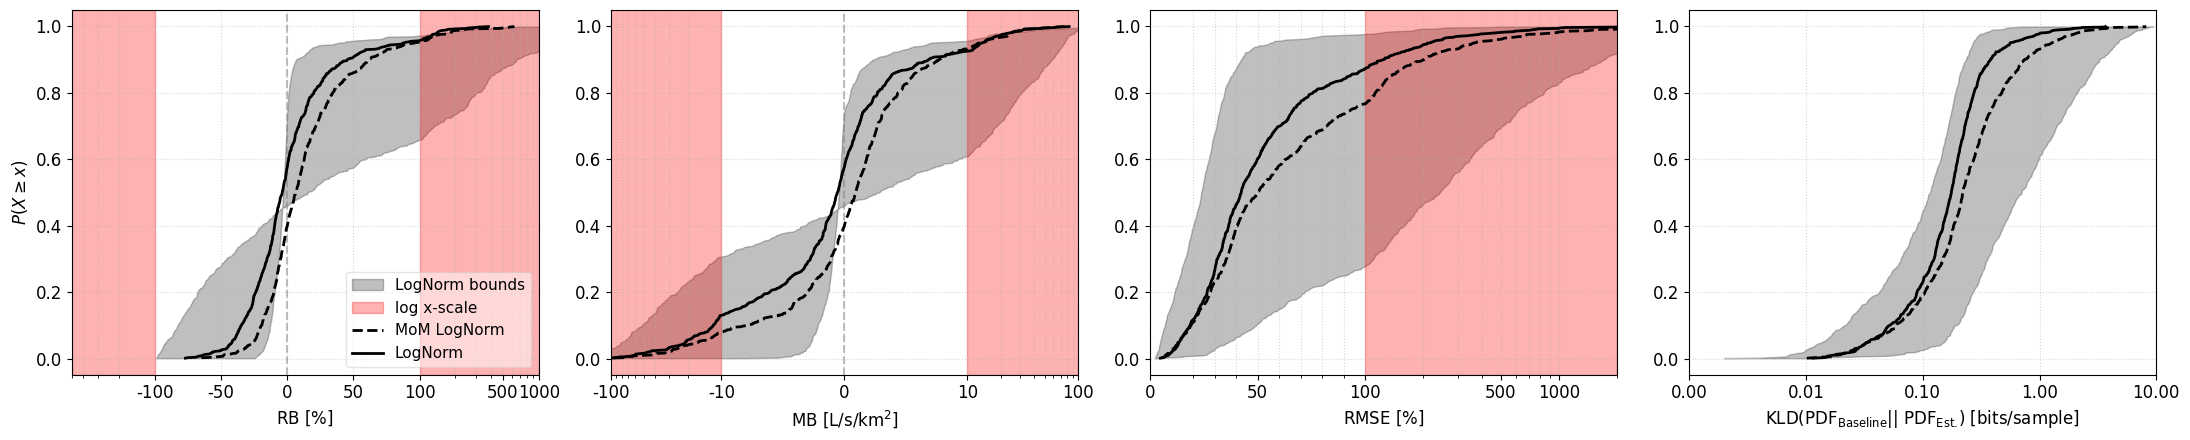

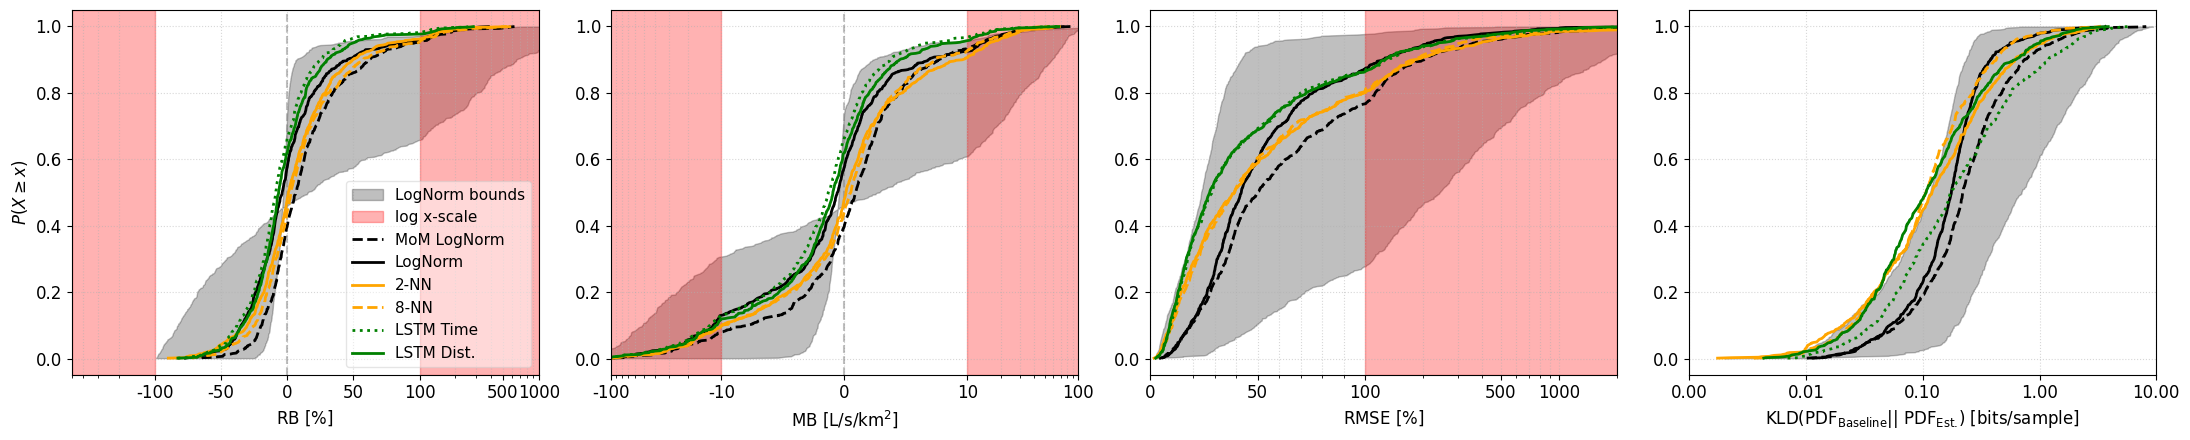

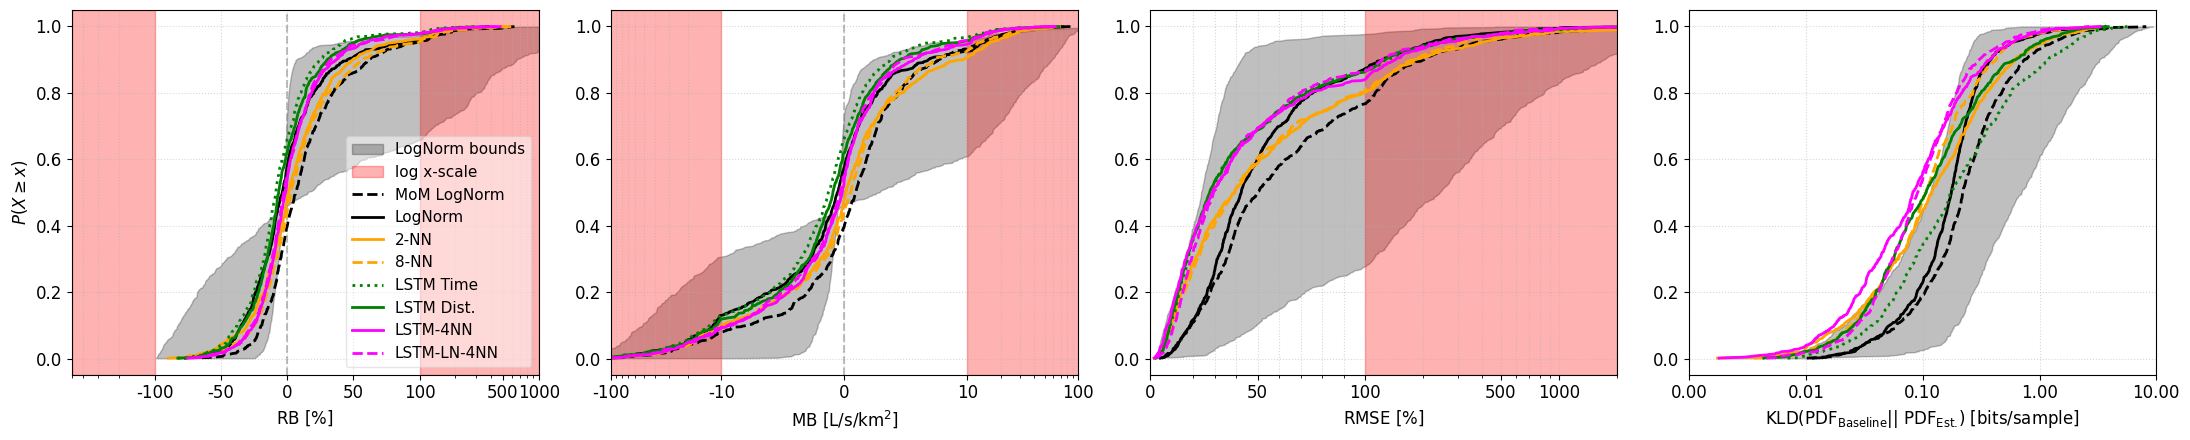

In [27]:
set_idxs = [2, 6, 10]
f1 = 'parametric_results.png'
f2 = 'LSTM_result_plots.png'
f3 = 'model_ensemble_results.png'
labels = [f1, f2, f3]
for idx, fname in zip(set_idxs, labels):
    fig = create_model_performance_plots_matplotlib(
        all_metrics, axis_labels, model_specs,
        fdc_df, get_knn_group_results,
        get_result_and_ids, main_result_vals, idx, ncols=4,
    )
    fp = 'images/' + fname
    fig.savefig(fp, dpi=150)
    print(f'saved to {fp}') 

In [28]:
bottom_10pct_ids = {}
for m in main_result_vals.keys():
    df = main_result_vals[m].copy()
    df.sort_values('values', ascending=False, inplace=True)
    # get the ids of the highest 10% of values (worst scores)
    bottom_10pct = df.iloc[:int(len(df) * 0.1)]
    bottom_10pct_ids[m] = pd.DataFrame({'ids': bottom_10pct['ids'].values, 'values': bottom_10pct['values'].values})

Note in the comparison above the DKL metrics have roughly 10% +inf values because despite the tails being well-described, the parametric approach still yields underspecified models of the observations!  **Note that the two methods are not directly comparable, since the DKL is in units of bits while the EMD is in units of the original data.**  We are not comparing these two divergence measures against each other, rather we are making a comparison between the two methods of generating LN parameters.  On this basis, in terms of both DKL and EMD metrics, the log-mean and log-stdev approach is expected to yield closer approximations of the FDCs than the mean and stdev approach.  It is not entirely clear what contributes more to this outcome, the normalization of variance or the structural error introduced by the method of moments.  

### Model variant regressions

Compare how the measures correlate within methods:

* what does the temporal vs. distribution averaging do for each metric?

In [29]:
main_result_vals.keys()

dict_keys(['MoM LogNorm RB', 'LogNorm RB', '2-NN RB', '8-NN RB', 'LSTM Time RB', 'LSTM Dist. RB', 'LSTM-4NN RB', 'LSTM-LN-4NN RB', 'MoM LogNorm MB', 'LogNorm MB', '2-NN MB', '8-NN MB', 'LSTM Time MB', 'LSTM Dist. MB', 'LSTM-4NN MB', 'LSTM-LN-4NN MB', 'MoM LogNorm RMSE', 'LogNorm RMSE', '2-NN RMSE', '8-NN RMSE', 'LSTM Time RMSE', 'LSTM Dist. RMSE', 'LSTM-4NN RMSE', 'LSTM-LN-4NN RMSE', 'MoM LogNorm KLD', 'LogNorm KLD', '2-NN KLD', '8-NN KLD', 'LSTM Time KLD', 'LSTM Dist. KLD', 'LSTM-4NN KLD', 'LSTM-LN-4NN KLD'])

In [30]:
combined_labels = [c for c in main_result_vals.keys() if (('LSTM' in c) & ('NN' in c)) | ('LN' in c)]
print(combined_labels)
LN_method_labels = [c for c in main_result_vals.keys() if ('LogNorm' in c) & (c not in combined_labels)]
print(LN_method_labels)
kNN_method_labels = [c for c in main_result_vals.keys() if ('NN' in c) & (c not in combined_labels)]
print(kNN_method_labels)
LSTM_method_labels = [c for c in main_result_vals.keys() if ('LSTM' in c) & (c not in combined_labels)]
print(LSTM_method_labels)

['LSTM-4NN RB', 'LSTM-LN-4NN RB', 'LSTM-4NN MB', 'LSTM-LN-4NN MB', 'LSTM-4NN RMSE', 'LSTM-LN-4NN RMSE', 'LSTM-4NN KLD', 'LSTM-LN-4NN KLD']
['MoM LogNorm RB', 'LogNorm RB', 'MoM LogNorm MB', 'LogNorm MB', 'MoM LogNorm RMSE', 'LogNorm RMSE', 'MoM LogNorm KLD', 'LogNorm KLD']
['2-NN RB', '8-NN RB', '2-NN MB', '8-NN MB', '2-NN RMSE', '8-NN RMSE', '2-NN KLD', '8-NN KLD']
['LSTM Time RB', 'LSTM Dist. RB', 'LSTM Time MB', 'LSTM Dist. MB', 'LSTM Time RMSE', 'LSTM Dist. RMSE', 'LSTM Time KLD', 'LSTM Dist. KLD']


In [31]:
def bootstrap_l1_slope_test(x, y, n_bootstraps=1000, alpha=0.05, delta=0.1, random_state=42):
    rng = np.random.default_rng(random_state)
    n = len(x)
    
    # Pre-generate all bootstrap indices (n_bootstraps x n)
    idxs = rng.integers(0, n, size=(n_bootstraps, n))
    
    # Pre-allocate array for slopes
    slopes = np.empty(n_bootstraps)
    
    # Loop over bootstrap samples
    x_reshaped = x.reshape(-1, 1)
    for i in range(n_bootstraps):
        xi = x_reshaped[idxs[i]]
        yi = y[idxs[i]]
        slopes[i] = l1_fit(xi.ravel(), yi)[0]

    # Confidence interval
    lower = np.percentile(slopes, 100 * alpha / 2)
    upper = np.percentile(slopes, 100 * (1 - alpha / 2))
    mean_slope = np.mean(slopes)

    # Check for meaningful difference
    is_meaningfully_different = np.abs(mean_slope - 1) > delta

    return {
        'mean_slope': float(mean_slope),
        'ci': (float(lower), float(upper)),
        'is_meaningfully_different': is_meaningfully_different,
        'bootstrapped_slopes': slopes
    }
    

def bootstrap_l2_slope_test(x, y, n_bootstraps=1000, alpha=0.05, delta=0.1, seed=None):
    """
    Perform bootstrap test on OLS slope to assess if it is meaningfully different from 1.

    Parameters:
    - x, y: 1D arrays of input data
    - n_bootstraps: number of bootstrap samples
    - alpha: significance level (e.g., 0.05 for 95% CI)
    - meaningful_diff: threshold for deviation from 1 to be considered meaningful
    - seed: optional random seed for reproducibility

    Returns:
    - dict with:
        - mean_slope: mean of bootstrap slopes
        - ci: confidence interval (lower, upper)
        - is_meaningfully_different: whether slope differs from 1 by more than `meaningful_diff`
        - bootstrapped_slopes: full array of bootstrapped slope samples
    """
    if seed is not None:
        np.random.seed(seed)

    x = np.asarray(x).reshape(-1, 1)
    y = np.asarray(y)
    n = len(x)

    slopes = np.empty(n_bootstraps)
    for i in range(n_bootstraps):
        idx = np.random.randint(0, n, n)
        xi, yi = x[idx], y[idx]
        slope, intercept, r, p, se = linregress(xi.ravel(), yi)
        slopes[i] = slope

    mean_slope = np.mean(slopes)
    lower, upper = np.percentile(slopes, [100 * alpha / 2, 100 * (1 - alpha / 2)])
    is_meaningfully_different = (upper < 1 - delta) or (lower > 1 + delta)

    return {
        'mean_slope': float(mean_slope),
        'ci': (float(lower), float(upper)),
        'is_meaningfully_different': is_meaningfully_different,
        'bootstrapped_slopes': slopes,
    }
    

def l1_fit(x, y):
    model = QuantileRegressor(quantile=0.5, alpha=0).fit(x.reshape(-1, 1), y)
    slope = model.coef_[0]
    intercept = model.intercept_
    return slope, intercept


def symlog_transform_with_linear_region(v, lin_thresh=1):
    """Manual symlog transform: linear near 0, log beyond."""
    return np.where(np.abs(v) <= lin_thresh,
                    v,
                    np.sign(v) * (np.log(np.abs(v)) + np.log(lin_thresh)))


In [32]:
def clean_label(label, m):
    # if 'LSTM' in label:
    return label.replace('Dist', 'dist. avg.').replace('Time', 'time avg.').split(m)[0]


def plot_all_matplotlib(metrics, dataframes, units, n_rows=3, n_cols=4, font_size=12):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
    axes = axes.flatten()

    def plot_loglog(ax, x, y):
        # mask = (x > 1e-3) & (y > 1e-3)
        # x, y = x[mask], y[mask]
        slope, intercept, r, *_ = linregress(np.log(x), np.log(y))
        bootstrap_slope_results = bootstrap_l2_slope_test(np.log(x), np.log(y))
        for k, v in bootstrap_slope_results.items():
            if k == 'bootstrapped_slopes':
                continue
            else:
                print(k, v)
        xx = np.linspace(np.min(x), np.max(x), 100)
        yy = np.exp(slope * np.log(xx) + intercept)
        ci_low, ci_high = bootstrap_slope_results['ci']
        yy_lower = np.exp(ci_low * np.log(xx) + intercept)
        yy_upper = np.exp(ci_high * np.log(xx) + intercept)
        
        ax.plot([x.min(), x.max()], [x.min(), x.max()], linestyle='dotted', color='black', linewidth=2.5, label='1:1')
        ax.scatter(x, y, s=5, alpha=0.6)
        band_label = f"95% CI m=[{ci_low:.2f}, {ci_high:.2f}]"
        ax.fill_between(xx, yy_lower, yy_upper, color='red', alpha=0.3, label=band_label)
        label = f'Y={slope:.2f}x + {intercept:.1f}'
        label = f'Y = exp({intercept:.2f})·X^{slope:.2f}'
        ax.plot(xx, yy, color='red', label=label, linewidth=2.5)
        ax.set_xscale('log')
        ax.set_yscale('log')
        
    def plot_symlog(ax, x, y, linthresh=1.):
        
        nan_x = np.sum(np.isnan(x))
        nan_y = np.sum(np.isnan(y))
        assert nan_x == 0, f'{nan_x} nan x values'
        assert nan_y == 0, f'{nan_y} nan y values'
        
        log_x = np.sign(x) * np.log(np.abs(x))
        log_y = np.sign(y) * np.log(np.abs(y))
        bootstrap_slope_results = bootstrap_l1_slope_test(log_x, log_y)
        bs_slope = bootstrap_slope_results['mean_slope']
        ci_low, ci_high = bootstrap_slope_results['ci']
                
        slope, intercept = l1_fit(log_x, log_y)
        # Sample more points around linear region
        x_lin = np.linspace(-lin_thresh, linthresh, 100)
        x_left = np.linspace(round(np.min(x), 1), -lin_thresh, 50, endpoint=False)
        x_right = np.linspace(linthresh, np.max(x), 50)

        xx = np.concatenate([x_left, x_lin, x_right])
        yy = np.exp(slope * xx + intercept)
        ax.add_patch(Rectangle((-lin_thresh, -lin_thresh), 2*lin_thresh, 2*lin_thresh,
                               facecolor='grey', alpha=0.3, zorder=0, label='linear scale'))  
        ax.plot([x.min(), x.max()], [x.min(), x.max()], linestyle='dotted', color='black', linewidth=2.5, label='1:1')
        ax.scatter(x, y, s=5, alpha=0.6) 

        ax.set_xscale('symlog', linthresh=lin_thresh)
        ax.set_yscale('symlog', linthresh=lin_thresh)      

    for ax, m, df, unit in zip(axes, metrics, dataframes, units):
        x, y = df.iloc[:, 0].values, df.iloc[:, 1].values
        is_symlog = m in ['RB', 'MB']
        print(m)
        if is_symlog:
            lin_thresh = 10 if m == 'MB' else 100
            plot_symlog(ax, x, y, lin_thresh)            
        else:
            plot_loglog(ax, x, y)

        ax.set_title(('MRE' if m == 'RE' else m) + f' {unit}', fontsize=font_size)
        ax.set_xlabel(clean_label(df.columns[0], m), fontsize=font_size)
        ax.set_ylabel(clean_label(df.columns[1], m), fontsize=font_size)
        ax.tick_params(labelsize=font_size - 2)
        ax.legend(fontsize=font_size - 3, framealpha=0.4)
        ax.grid(True, which='both', linestyle=':', alpha=0.5)

    for i in range(len(metrics), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    return fig

RB
MB
RMSE
mean_slope 0.9233128844016069
ci (0.8435301683643834, 0.9940328270519386)
is_meaningfully_different False
KLD
mean_slope 0.8850364646782206
ci (0.8112209180807107, 0.9542822643222395)
is_meaningfully_different False


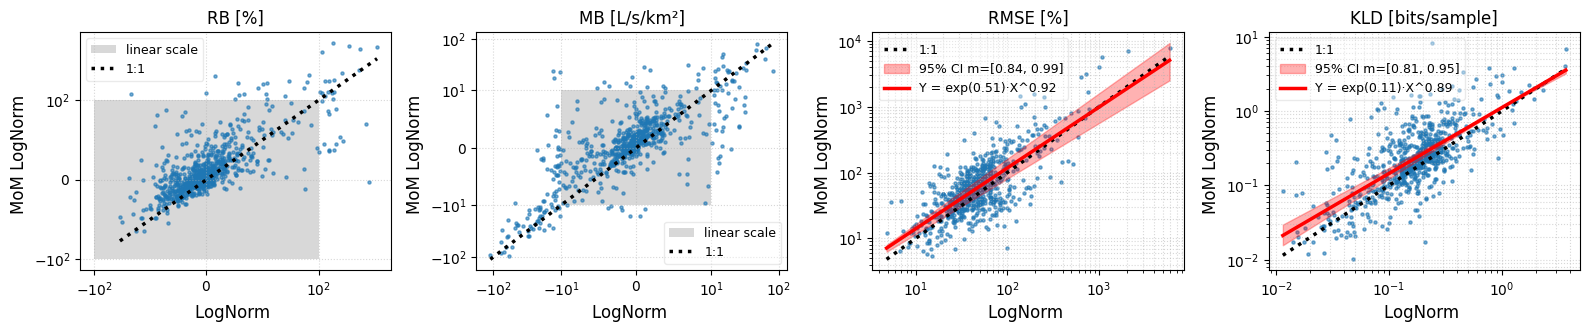

In [33]:
plot_dfs = []
units = ['[%]', '[L/s/km²]', '[%]', '[bits/sample]']
for m, unit in zip(all_metrics, units):
    cols = list(sorted([c for c in LN_method_labels if m in c]))
    dfs = []
    for c in cols:
        data = main_result_vals[c].copy().set_index('ids')
        dfs.append(data)
    df = pd.concat(dfs, join='inner',axis=1)
    df.columns = cols
    plot_dfs.append(df)

figs = plot_all_matplotlib(all_metrics, plot_dfs, units)
figs.savefig("LN_mom_vs_direct_plots.png", dpi=150, bbox_inches='tight')

plt.show()

2-NN RB: mean RB=8.75
8-NN RB: mean RB=13.96
2-NN MB: mean MB=-0.46
8-NN MB: mean MB=-0.87
2-NN RMSE: mean RMSE=187.58
8-NN RMSE: mean RMSE=99.54
2-NN KLD: mean KLD=0.27
8-NN KLD: mean KLD=0.19
RB
MB
RMSE
mean_slope 0.782638077364619
ci (0.7449240287536013, 0.8215521774078218)
is_meaningfully_different True
KLD
mean_slope 0.7087806122489049
ci (0.6732253699700094, 0.7473340005475977)
is_meaningfully_different True


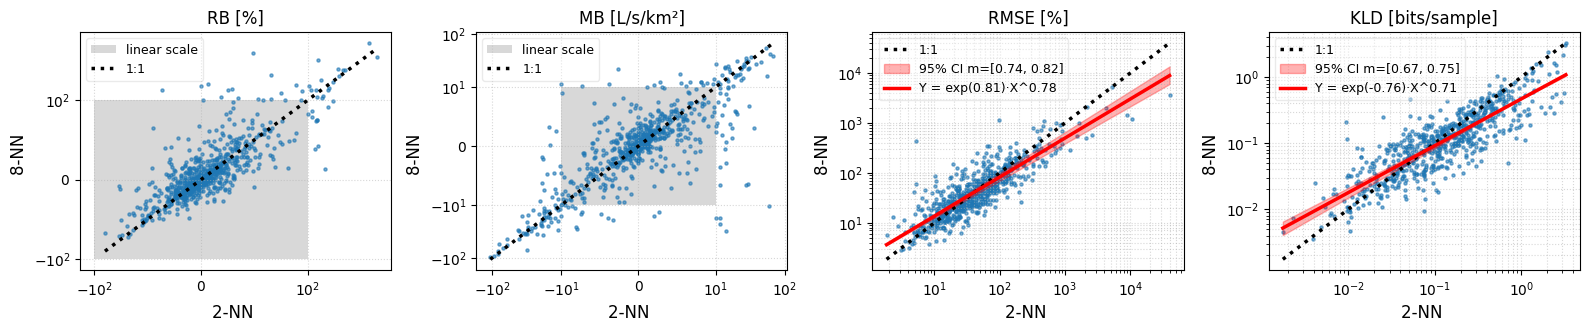

In [34]:
plot_dfs = []
for m in all_metrics:
    cols = list(sorted([c for c in kNN_method_labels if m in c]))
    dfs = []
    for c in cols:
        data = main_result_vals[c].copy().set_index('ids')
        print(f'{c}: mean {m}={np.mean(data):.2f}')
        dfs.append(data)
    df = pd.concat(dfs, join='inner',axis=1)    
    df.columns = cols
    plot_dfs.append(df)

figs = plot_all_matplotlib(all_metrics, plot_dfs, units)
figs.savefig("knn_8_vs_2.png", dpi=150, bbox_inches='tight')
plt.show()

RB
MB
RMSE
mean_slope 0.9818137606729467
ci (0.9698010693540177, 0.9934357291603366)
is_meaningfully_different False
KLD
mean_slope 0.9918212851374248
ci (0.9654571843300387, 1.0189289725048176)
is_meaningfully_different False


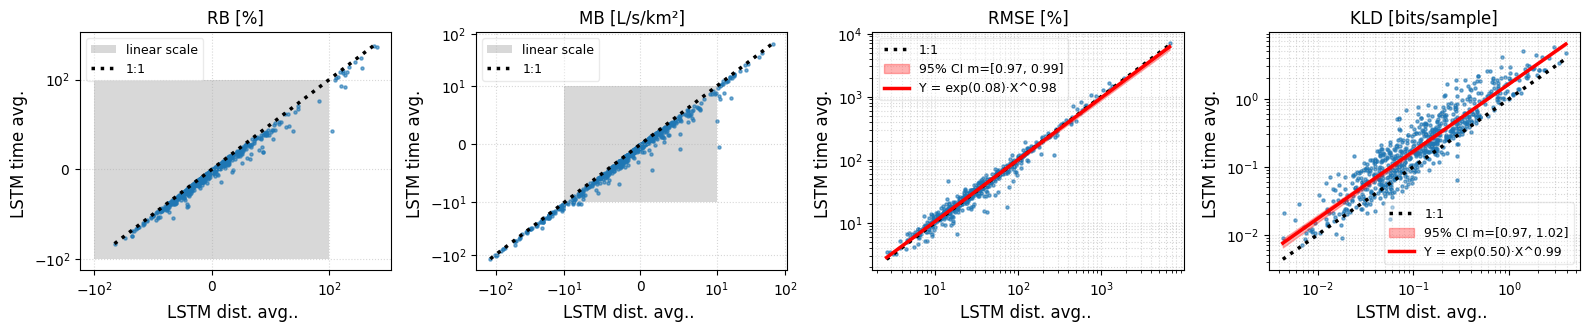

In [35]:
plot_dfs = []
for m in all_metrics:
    # cols = list(sorted([c for c in LSTM_method_labels if m in c]))
    # cols = [c for c in cols if 'knn_lstm' not in c]
    cols = list(sorted([c for c in main_result_vals.keys() if c.startswith('LSTM')]))
    cols = [c for c in cols if c.endswith(m)]
    dfs = []
    for c in cols:
        data = main_result_vals[c].copy().set_index('ids')
        dfs.append(data)
    df = pd.concat(dfs, join='inner',axis=1)
    df.columns = cols
    plot_dfs.append(df)

figs = plot_all_matplotlib(all_metrics, plot_dfs, units)
figs.savefig('LSTM_time_vs_distribution_plots.png', dpi=150, bbox_inches='tight')
plt.show()

## Rank Correlations

One interesting characteristic of the results is that about 20% of the sites can't do better than 0.4 bits/sample entropy, and that the parametric estimation is the best approach for these.  One question we can ask about this 20% is whether it's the same sample across the disparate methods, and we can figure this out directly by checking the size of the common set of ids in the worst (highest KLD/EMD) 20%.  

* are there sites that are difficult to predict, regardless of the method?
* are there methods that work better on some sites compared to others?
* are there metrics that work better on some sites compared to others?

In [36]:
def regression_scatter_plots(md, main_result_vals, plot_type='rank'):
    model_set = [e for e in main_result_vals.keys() if e.endswith(f' {md}')]
    model_set = [e for e in model_set if not e.startswith('LN MoM')]
    model_set = [e for e in model_set if not e.startswith('PredictedLMomentsGEV')]
    model_set = [e for e in model_set if 'time' not in e]
    model_set = [e for e in model_set if "MLE" not in e]
    # model_set = [e for e in model_set if '1950' not in e]
    # get unordered pairs of models
    from itertools import combinations
    model_pairs = list(combinations(model_set, 2))
    rank_scatter_plots = []
    model_labels = []
    for m1, m2 in model_pairs:
        if 'kNN' in m1 and 'kNN' in m2:
            continue
        if '3' in m1 or '3' in m2:
            continue
        # get ranking of md values and make a scatter plot
        df1 = main_result_vals[m1].copy()
        df2 = main_result_vals[m2].copy()
        if df1.empty or df2.empty:
            continue
        ascending = False if md in ['NSE', 'KGE'] else True
        df1.sort_values('values', ascending=ascending, inplace=True)
        df2.sort_values('values', ascending=ascending, inplace=True)
        df1['rank'] = np.arange(len(df1)) + 1
        df2['rank'] = np.arange(len(df2)) + 1
        # merge the two dataframes on ids
        merged = pd.merge(df1, df2, on='ids', suffixes=('_1', '_2'))
        # create a scatter plot of the ranks
        p = figure(title=f"{md}", width=350, height=300)
        if plot_type == 'rank':
            p.scatter(merged['rank_1'], merged['rank_2'], size=3)
            slope, intercept, r_value, p_value, std_err = linregress(merged['rank_1'], merged['rank_2'])
            xvals = [1, len(merged)]
            yvals = [1, len(merged)]
        else:
            p.scatter(merged['values_1'], merged['values_2'], size=3)
            slope, intercept, r_value, p_value, std_err = linregress(merged['values_1'], merged['values_2'])
            xvals = [merged['values_1'].min(), merged['values_1'].max()]
            yvals = [slope * x + intercept for x in xvals]

        p.line(xvals, yvals, line_dash='dashed', color='black', line_width=2, legend_label='1:1')
        p.line(xvals, yvals, line_color='red', line_width=2, legend_label=f'R²={r_value**2:.2f}')
        def get_plot_axis_label(m):
            if 'LN' in m:
                return 'LogNorm Direct Rank'
            elif 'LSTM' in m:
                print(m)
                return 'LSTM Rank'
            elif '9 kNN' in m:
                return '9-NN Rank'
            elif '3 kNN' in m:
                return '3-NN Rank'
            else:
                return m
        
        if plot_type == 'rank':
            x_label, y_label = get_plot_axis_label(m1), get_plot_axis_label(m2)
            p.xaxis.axis_label = x_label
            p.yaxis.axis_label = y_label
        else:
            p.xaxis.axis_label = f'{m1[:-3]} {md}'
            p.yaxis.axis_label = f'{m2[:-3]} {md}'
        if m1 not in model_labels:
            model_labels.append(m1)
        if m2 not in model_labels:
            model_labels.append(m2)
        p.legend.location = 'top_left'
        p.legend.background_fill_alpha = 0.7
        p = dpf.format_fig_fonts(p, font_size=16)
        rank_scatter_plots.append(p)
    return rank_scatter_plots, model_labels

In [37]:
# show(gridplot(rank_plots, ncols=2, width=335, height=300))

Above: the outliers skew the meaning of the correlation between metrics from different methods.  The rank correlation is a better measure of the relationship between the methods, since it is not affected by the outliers.  

In [38]:
# create a dataframe with all the model results indexed by station
all_results = []
for m in main_result_vals.keys():
    df = main_result_vals[m].copy()
    df.rename(columns={'values': m}, inplace=True)
    df.set_index('ids', inplace=True)
    all_results.append(df)
all_results_df = pd.concat(all_results, axis=1)
foo = all_results_df[[c for c in all_results_df.columns if c.endswith('RMSE')]].copy()

## Convert RMSE back to linear units

RMSE was computed on log(UAR), and we should convert back to linear for presenting results.

In [39]:
# for c in all_results_df.columns:
#     if c.endswith('RMSE'):
#         all_results_df[c] = np.exp(all_results_df[c]) - 1 # represente as multiplicative error

In [40]:
all_results_df[[c for c in all_results_df.columns if c.endswith("RMSE")]].describe()

,MoM LogNorm RMSE,LogNorm RMSE,2-NN RMSE,8-NN RMSE,LSTM Time RMSE,LSTM Dist. RMSE,LSTM-4NN RMSE,LSTM-LN-4NN RMSE
count,719.000000,719.000000,719.000000,719.000000,719.000000,719.000000,719.000000,719.000000
mean,139.165991,80.606773,187.575351,99.539274,80.394139,76.628278,79.733316,73.604068
std,512.497977,252.806604,1605.050336,296.065338,309.055808,285.744581,269.819957,252.513779
min,5.363079,4.815942,1.851022,2.873628,3.180344,2.618213,1.995749,3.003625
25%,31.922306,29.601687,17.587121,18.889787,15.691728,15.130761,14.516998,17.222667
50%,50.216033,42.411452,39.301754,39.274272,28.799561,27.735294,29.068699,29.567985
75%,93.634850,66.794990,82.139509,82.710487,61.061489,60.712292,61.810100,60.952928
max,7683.096744,5880.870545,40033.082186,5302.631039,7085.433142,6637.446843,5820.847673,5829.082728


In [41]:

def plot_correlation_regression(df, all_metrics, correlation_type='pearson'):
    plots = []
    for md in all_metrics:
        model_cols = [c for c in df.columns if (c.endswith(f' {md}') and 'Time' not in c and '4NN' not in c)]
        print(model_cols)
        symlog_cols = [c for c in model_cols if c.endswith('RB') | c.endswith('MB')]
        log_cols = [c for c in model_cols if c not in symlog_cols]
        model_df = np.log(df[log_cols].copy())
        for c in symlog_cols:
            model_df[c] = [np.sign(x) * np.log(np.abs(x)) for x in df[c].values]
        foo = model_df.dropna(how='any')
        assert len(model_df) == len(foo), f'len(foo) = {len(foo)}'
        if md in ['NSE', 'KGE']:
            # for NSE and KGE, we want to plot the upper bound as the maximum value
            model_df = 1 - model_df
        corr_df = model_df.corr(method=correlation_type)
        if correlation_type == 'kendall':
            label = 'Kendall Tau Correlation'
        elif correlation_type == 'pearson':
            label = 'Pearson Correlation'
        else:
            raise ValueError(f"Unsupported correlation type: {correlation_type}")
        
        # Melt correlation matrix to long-form
        corr_long = corr_df.reset_index().melt(id_vars='index')
        corr_long.columns = ['x', 'y', 'value']
        ends = corr_long['x'].str.find(md)
        corr_long['x'] = [e[:i] for e, i in zip(corr_long['x'], ends)]
        ends = corr_long['y'].str.find(md)
        corr_long['y'] = [e[:i] for e, i in zip(corr_long['y'], ends)]
        # Create source
        source = ColumnDataSource(corr_long)
    
        # low, high = 0.1, 1.0
        min_val = min(corr_long['value'].min(), 0.1)
        low, high = min_val, 1.0
        n_colors = len(RdBu[10])
    
        # Bin edges and centers
        bounds = np.linspace(low, high, n_colors + 1)
        centers = 0.5 * (bounds[:-1] + bounds[1:])
    
        # Reverse the palette for consistency (if needed)
        palette = list(reversed(RdBu[10]))
        # Optional: format labels as strings with 2 decimals
        labels = [f"{c:.2f}" for c in centers]
        label_overrides = {c: l for c, l in zip(centers, labels)}
        mapper = LinearColorMapper(palette=palette, low=low, high=high)
        w, h = 270, 300
        if len(plots) == len(all_metrics) - 1:
            w = 280
        if (len(plots) > 0) & (len(plots) < len(all_metrics) - 1):
            w = 200
        x_label_idxs = [e.find(md) for e in corr_df.columns]
        x_labels = [e[:i] for e, i in zip(corr_df.columns, x_label_idxs)]
        y_labels = list(reversed(x_labels))
        fw, fh = w, h
        if len(plots) in [1, 2]:
            fw += 70
        
        p = figure(
            frame_width=fw,
            frame_height=fh,
            title=md,
            x_range=x_labels, y_range=y_labels, toolbar_location = 'above',
            tools="hover,save",  tooltips=[("Model Pair", "@x vs @y"), ("Corr", "@value{0.2f}")]
        )
    
        p.rect(x="x", y="y", width=1, height=1, source=source,
            fill_color=transform('value', mapper), line_color=None)            
    
        if len(plots) == len(all_metrics) - 1:
            color_bar = ColorBar(
                color_mapper=mapper,
                ticker=FixedTicker(ticks=centers.tolist()),
                formatter=PrintfTickFormatter(format=""),  # will be overridden
                major_label_overrides=label_overrides,
                major_label_text_font_size="10pt",
                label_standoff=6,
                border_line_color=None,
                location=(0, 0),
                title=label,
            )
            p.add_layout(color_bar, 'right')

        if len(plots) > 0:
            p.yaxis.visible = False
    
        # Axis styling
        p.axis.major_label_text_font_size = "10pt"
        p.axis.major_label_standoff = 0
        p.xaxis.major_label_orientation = np.pi / 2
        p = dpf.format_fig_fonts(p, font_size=14)
        plots.append(p)
        
    return plots



In [42]:
correlation_plots = plot_correlation_regression(all_results_df, all_metrics, correlation_type='kendall')
# lt = row(correlation_plots)
lt = gridplot(correlation_plots, ncols=4)
show(lt)

['MoM LogNorm RB', 'LogNorm RB', '2-NN RB', '8-NN RB', 'LSTM Dist. RB']
['MoM LogNorm MB', 'LogNorm MB', '2-NN MB', '8-NN MB', 'LSTM Dist. MB']
['MoM LogNorm RMSE', 'LogNorm RMSE', '2-NN RMSE', '8-NN RMSE', 'LSTM Dist. RMSE']
['MoM LogNorm KLD', 'LogNorm KLD', '2-NN KLD', '8-NN KLD', 'LSTM Dist. KLD']


## Examine how ranks change between metrics

We have seen how the rank correlations compare between methods for the same metric, and this tells us that some methods are complementary, that is they may capture different aspects of the data or model performance. Another perspective is to look at how the ranks change by metric, in other words to see where metrics agree and disagree about the relative performance of methods.


### kNN - based FDC approximation

Next we consider the various interpretations of kNN we used to generate the FDC from streamflow observations in the network.  The kNN represents a hedging of risk against the criteria used to select the proxy to represent the target location.  The "nearest neighbour" constraint represents an assumption that the closest locations are most representative, but the choice of neighbouring set interacts with the secondary constraint of concurrency of records, which is a practical reality of environmental observation.  The data concurrency constraint means we discard some of the observations of both the target and the proxy in defining the FDCs, and also discard potential proxies that might be more representative of the target because of a lack of sufficient concurrent record. 

The goal is to better understand the trade-off between the selection criteria and the performance of the kNN method under as broad a range of conditions as possible.  On the one hand, we can be strict in the temporal sense that it is only valid to compare observations that occurred at the same time, but another interpratation is that a significant proportion of the interannual variability can be captured given sufficient data, and more of the interannual variability can be covered by not requiring concurrency.  Strictness in the spatial (neighbour) sense means we take exactly the same k neighbours, but this leads to loss of data because more distant neighbours must be sought to satisfy the "k" contributors constraint, whereas we can interpret it as "take the best information where it's available, and resort to potentially less relevant contributors if necessary to fill gaps.


The next sets of plots represent different ways to control the preservation of information in the kNN method:

1.  Look across k neighbours for the same method of selecting neighbours (e.g., IDW, CAS, etc.) to see how the kNN method performs as a function of k.  This will help us understand the trade-off between the number of neighbours and the performance of the kNN method.



In [43]:
def create_knn_plots_matplotlib_grid(results_dfs, completed_stns, all_metrics, axis_labels, ncols=3, savepath=None):
    import matplotlib.pyplot as plt
    from matplotlib.ticker import NullFormatter
    from bokeh.palettes import Sunset10

    knn_df = results_dfs['knn'].copy()
    combos = [
        ('ID2', 'timeEnsemble', 'spatial'),
        ('ID2', 'freqEnsemble', 'spatial'),
        ('ID2', 'freqEnsemble', 'attribute'),
    ]
    metric_label_dict = dict(zip(all_metrics, axis_labels))
    clrs = Sunset10
    ncols = len(combos)

    total = len(all_metrics) * len(combos)
    nrows = (total + ncols - 1) // ncols
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))
    axs = axs.flatten()
    plot_idx = 0

    parametric_df = results_dfs['parametric'].copy()

    for metric in all_metrics:
        print(metric)
        for wm, ensemble, tree in combos:
            df = knn_df.query(
                "ensemble_weight == @wm and ensemble_method == @ensemble and tree_type == @tree"
            )
            if df.empty:
                print(f"No data for {tree} {ensemble} {metric}")
                continue

            ax = axs[plot_idx]        
            plot_idx += 1
            linthresh = 1.0
            max_val = plot_parametric_bounds_matplotlib(ax, metric, fdc_df)
            is_symlog = metric in ['RB', 'MB', 'RMSE']
            # tick_loc = 1
            if is_symlog:
                ax.axvline(0, ymin=0, ymax=1, color='grey', linestyle='dashed', alpha=0.5)
                linthresh = 100 if metric == 'RB' else 10
                ax.set_xscale('symlog', linthresh=linthresh)
                ax.set_xlim(-100, 1000)
                if metric == 'RB':
                    ax.axvspan(-1000, -linthresh, color='red', alpha=0.25, label='log x-scale')
                    ax.axvspan(linthresh, 10000, color='red', alpha=0.25)
                    linear_ticks = np.arange(-linthresh + 50, linthresh, 50)
                elif metric == 'RMSE':
                    ax.set_xlim(0, 1000)
                    linthresh = 100
                    ax.axvspan(linthresh, 10000, color='red', alpha=0.25, label='log x-scale')
                    # ax.axvspan(linthresh, 10000, color='red', alpha=0.25)
                    linear_ticks = np.arange(0, linthresh, 50)
                else:
                    ax.set_xlim(-100, 200)
                    ax.axvspan(-10000, -linthresh, color='red', alpha=0.25, label='log x-scale')
                    ax.axvspan(linthresh, 10000, color='red', alpha=0.25)
                    linear_ticks = np.arange(0, linthresh+1, 50)
                    
                ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))   
                # Optional: minor ticks in log zones
                ax.xaxis.set_minor_locator(SymmetricalLogLocator(base=10, linthresh=linthresh, subs=np.arange(2, 10)))
                
                # Keep your custom formatter
                ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
                # Combine with existing ticks (outside linear region)
                existing_ticks = ax.get_xticks()
                all_ticks = np.unique(np.concatenate([existing_ticks, linear_ticks]))
                ax.set_xticks(all_ticks)                
                
                # Show grid for both major and minor ticks
                ax.grid(True, which='both', linestyle=':', alpha=0.5)
                
            else:
                ax.set_xlim(1e-3, 10)
                ax.set_xscale('log')
                ax.xaxis.set_minor_formatter(NullFormatter())
                ax.grid(True, which='both', linestyle=':', alpha=0.5)

            for i in range(1, 11):
                vals = df[df['k'] == str(i)][metric].values
                assert len(vals) == len(completed_stns)
                if metric in ['NSE', 'KGE']:
                    vals = 1 - vals
                x, y = compute_empirical_cdf(vals)
                ax.plot(x, y, label=f'{i}NN', color=clrs[i - 1], lw=2)

            # Parametric benchmark
            pv = parametric_df[parametric_df['Label'] == 'PredictedLog'][metric].values
            if metric in ['NSE', 'KGE']:
                pv = 1 - pv
            x, y = compute_empirical_cdf(pv)
            ax.plot(x, y, label='PredictedLog', color='black', lw=2.5)

            ax.set_xlabel(metric_label_dict[metric][1:-1])
            e_label = 'timeEnsemble' if ensemble.startswith('time') else 'distEnsemble'
            ax.set_ylabel(r'$P(X \geq x)$')
            ax.set_title(f'{e_label} / {tree}: {wm}', fontsize=10)
            ax.legend(fontsize=7, loc='lower right', framealpha=0.6)
            ax.grid(True, which='both', linestyle=':', alpha=0.5)

    # Remove unused subplots
    for j in range(plot_idx, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=150)
    return fig

RB
MB
RMSE
KLD


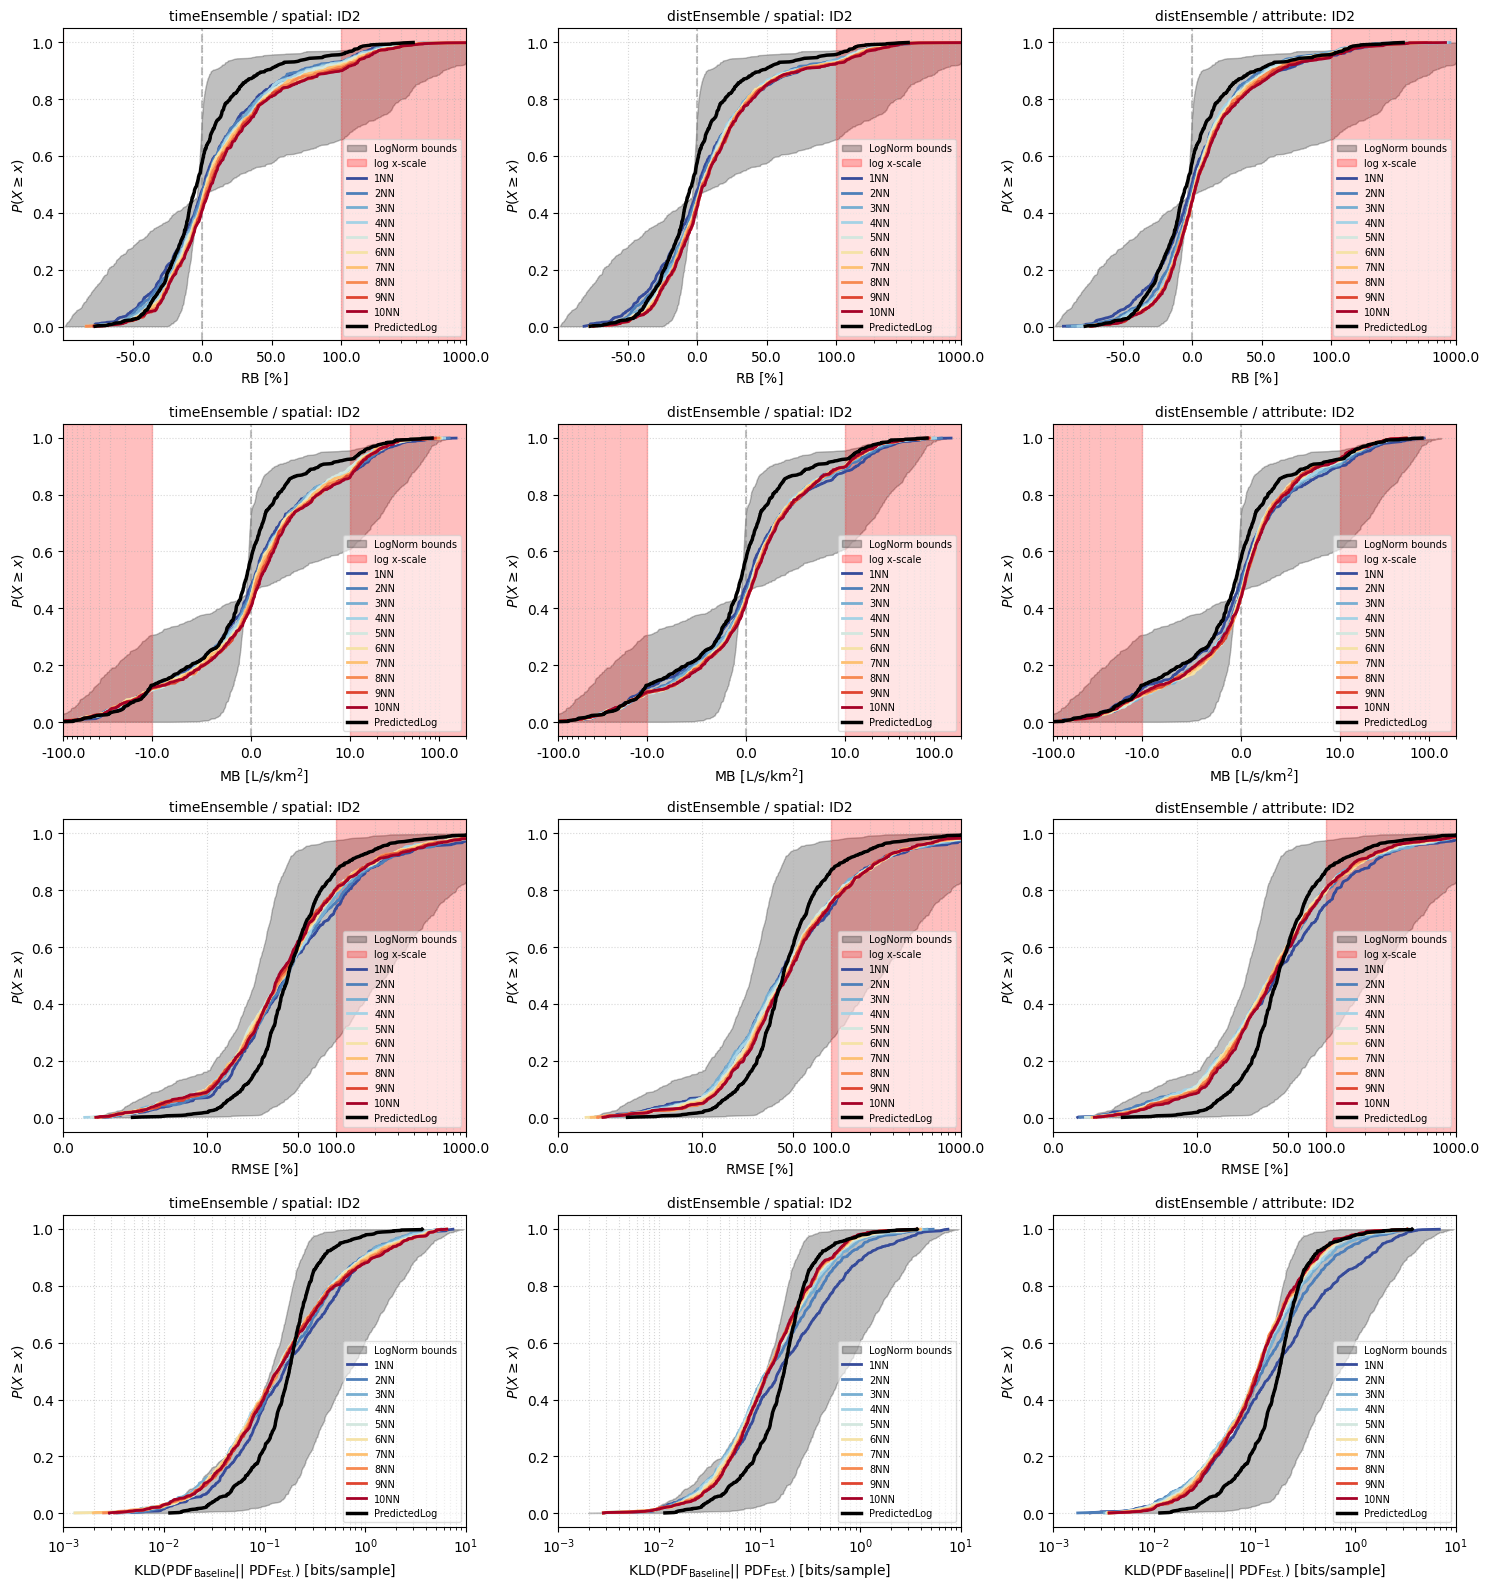

In [44]:
plots = create_knn_plots_matplotlib_grid(results_dfs, completed_stns, all_metrics, axis_labels, ncols=3, savepath='images/knn_plot_subset.png')

In temporal ensemble averaging, larger ensembles do worse at already poorly predicted locations by reducing variance.

The plots above compare ensembles of k NN averaged over the **time domain**, showing that across the (EW, IDW, and CAS) weighting/selection methods and across DKL and EMD divergence metrics, selecting just 1 neighbour yields poorer FDC approximations.  The behaviour of the worst ~20% of the FDC approximations is counter-intuitive for the DKL metric because it would seem that adding contributors hedges against outliers at the expense of weakening the small number of cases where there happens to be a very good proxy.

Now keep all else constant and compare k neighbour ensembles in the **frequency domain**.  Note that the maxk, strictk, effectivek, and dynamick variants are not compared in the frequency domain.

Across both DKL and EMD metrics, adding neighbours in the frequency domain averaging has the effect of hedging risk against outliers, with a penalty on the best 20% of predictions.  For a small tradeoff in the best predictions, the poorest ~50% are improved in the KLD metric -- however there is little or no effect in the worst performing percentile range of the EMD.

The predicted parametric is a more pronounced tradeoff between limiting downside risk at the expense of upside gain.

Next we look at the effect of varying the interpretation of kNN as far as handling gaps in the record.  If the goal is to preserve as much information as possible, we can first relax the constraint of having exactly k consistent neighbours contribute observations concurrent with the target.  We can go further by allowing the number of contributors to increase until we get an average of k observations per timestep, increasing the number of neighbours but holding the larger set constant.  We can go even further and look for exactly k neighbours at each timestep, thereby not requiring the ensemble simulation to be drawn from the same set of neighbours.  

Above, the downside risk hedging effect of the frequency-averaged ensemble increases with the number of neighbours based on the KL divergence metric, with a smaller penalty for the best approximations.  The EMD metric shows a different trend, where it represents the best expected approximation compared to all other temporally-averaged ensembles, but it is counter-intuitive that the variants are so spread apart for small k.  The log-mean and stdev parametric approximation still suppresses the tails and represents the "safest" bet for the worse half of the sample for both EMD and DKL metrics compard to the time ensemble.  The best of each freqency-averaged ensemble is shown for comparison.  For increasing k, the top few % of time-averaged ensembles are slighly better than the frequency-averaged ensembles.

We've kept the three neighbour selection / weighting methods (EW, IDW, CAS) separate so far.  Now let's compare them for equal k.

Selecting neighbours by attribute similarity (CAS) yields slightly better FDC predictions across the full sample.  

For large scale assessments, there is a clear case for frequency over time-based ensembles, and we saw that the kNN method estimation performance was very sensitive to the strictness of adherence to the kNN in terms of the "effective number of contributors per timestep".  Now we take it to the logical extreme and remove the requirement that we compare concurrent periods of record.  The idea being that a minimum of five years of observations at a location captures much of the inter-annual variability, including the El Nino period, but not longer durations like the PDO or longer term climate trends.  

so to reduce the visual clutter we will keep the log-normal parametric approximation and the frequency-averaged ensemble based on catchment attribute similarity and add one last comparison, the LSTM-based approximation.

## Multi-model ensembles

Given the low rank correlation between certain methods, here we explore the potential benefits of combining multiple models as ensembles.

In [45]:
# load the baseline PMFs from the previous notebook
pmf_path = Path(os.getcwd()) / 'data' / 'results' / 'baseline_distributions' / f'bcub_pmfs.csv'
pmf_df = pd.read_csv(pmf_path, index_col=0)
pmf_stations = pmf_df.columns
assert np.all(np.isin(pmf_stations, station_ids)), "Not all stations with a baseline PMF are in the attribute station set."

In [46]:
dam_sites = ['12398000', '12058800', '12143700', '12323760'] 
official_ids_to_include = [s for s in pmf_stations if s not in dam_sites]

In [47]:
# load the predicted parameter results
parameter_prediction_results_folder = os.path.join('data', 'results', 'parameter_prediction_results', )
predicted_params_fpath   = os.path.join(parameter_prediction_results_folder, 'mean_parameter_predictions.csv')
rdf = pd.read_csv(predicted_params_fpath, index_col=['official_id'], dtype={'official_id': str})
predicted_param_dict = rdf.to_dict(orient='index')
predicted_param_dict['0212414900'].keys()

dict_keys(['uar_mean_mean_predicted', 'uar_mean_actual', 'uar_std_mean_predicted', 'uar_std_actual', 'uar_median_mean_predicted', 'uar_median_actual', 'uar_mad_mean_predicted', 'uar_mad_actual', 'log_uar_mean_mean_predicted', 'log_uar_mean_actual', 'log_uar_std_mean_predicted', 'log_uar_std_actual', 'log_uar_median_mean_predicted', 'log_uar_median_actual', 'log_uar_mad_mean_predicted', 'log_uar_mad_actual'])

In [48]:
LSTM_forcings_folder = '/home/danbot/neuralhydrology/data/BCUB_catchment_mean_met_forcings_20250320'
# LSTM_ensemble_result_folder = '/home/danbot/code/neuralhydrology/data/ensemble_results'
attr_df_fpath = os.path.join('data', f'catchment_attributes_with_runoff_stats.csv')
baseline_distribution_folder = 'data/results/baseline_distributions'

methods = ('parametric', 'lstm', 'knn',)
# methods = ('knn',)
include_pre_1980_data = True  # use only stations with data 1980-present concurrent with Daymet
daymet_start_date = '1980-01-01'  # default start date for Daymet data
if include_pre_1980_data:
    daymet_start_date = '1950-01-01'

input_data = {
    'attr_df_fpath': attr_df_fpath,
    'LSTM_forcings_folder': LSTM_forcings_folder,
    'LSTM_ensemble_result_folder': LSTM_ensemble_result_folder,
    'include_pre_1980_data': include_pre_1980_data,  # use only stations with data 1980-present concurrent with Daymet
    'predicted_param_dict': predicted_param_dict,
    'divergence_measures': ['DKL', 'EMD'],
    'eps': 1e-12,
    'min_flow': 1e-4,
    'n_grid_points': 2**12,
    'min_record_length': 5,
    'minimum_days_per_month': 20,
    'parametric_target_cols': target_cols,
    'all_station_ids': official_ids_to_include,
    'daymet_concurrent_stations': daymet_concurrent_stations,
    'baseline_distribution_folder': baseline_distribution_folder,
    'prior_strength': 1e-2,  # prior strength for the Laplace fit
}

fdc_context = FDCEstimationContext(**input_data)


    Using all stations in the catchment data with a baseline PMF (validated): 1093
    ...overlap dict loaded from data/record_overlap_dict.json


In [49]:
def compute_multi_model_ensemble_pmf(stn, rev_date, which_models):
    # load the knn_result
    knn_fpath = os.path.join(results_folder, 'knn', f'{stn}_fdc_results.json')
    knn_pmfs = {}
    with open(knn_fpath, 'rb') as file:
        knn_dict = json.load(file)
        # retrieve the PMF for the 4_NN_0_minOverlapPct_attribute_dist_ID2
        knn_models = list(knn_dict.keys())
        knn_models = [k for k in knn_models if '_NN_attribute_dist_ID2_freqEnsemble' in k]
        for m in sorted(knn_models):
            knn_pmfs[m] = knn_dict[m]['pmf']
            bias = knn_dict[m]['bias']
        assert knn_models, f'No knn model found for {stn}'
        # knn_pmf = knn_dict[knn_model[0]]['pmf']
        
    lstm_fpath = os.path.join(results_folder, f'lstm_{rev_date}', f'{stn}_fdc_results.json')
    with open(lstm_fpath, 'rb') as file:
        lstm_dict = json.load(file)
        lstm_pmf = lstm_dict['frequency']['pmf']

    param_fpath = os.path.join(results_folder, 'parametric', f'{stn}_fdc_results.json')
    with open(param_fpath, 'rb') as file:
        param_dict = json.load(file)
        # retrieve the PMF for the 'PredictedMOM' model
        param_models = list(param_dict.keys())
        param_model = [k for k in param_models if 'PredictedLog' in k]
        assert param_model, f'No parametric model found for {stn}'
        param_pmf = param_dict[param_model[0]]['pmf']
    # compute an ensemble PMF as the average of the knn and lstm PMFs
    # compute the mean ensemble element-wise
    ensemble_pmfs = {}
    if which_models == 'knn-lstm':
        # for m in param
        for m in knn_pmfs:
            ensemble_pmf = np.mean([knn_pmfs[m], lstm_pmf], axis=0)
            ensemble_pmf /= np.sum(ensemble_pmf)
            ensemble_pmfs[m] = ensemble_pmf
    elif which_models == 'knn-lstm-parametric':
        for m in knn_pmfs:
            ensemble_pmf = np.mean([knn_pmfs[m], lstm_pmf, param_pmf], axis=0)
            ensemble_pmf /= np.sum(ensemble_pmf)
            ensemble_pmfs[m] = ensemble_pmf
    return ensemble_pmfs

In [50]:
def compute_ensemble_divergence(stn, rev_date, which_models):
    station = StationData(fdc_context, stn)
    eval_object = EvaluationMetrics(station.baseline_log_grid, station.log_dx)
    kde = KDEEstimator(station.baseline_log_grid, station.log_dx)
    baseline_pmf, _ = kde.compute(
            station.stn_df[station.uar_label].values, station.target_da
        )
    ensemble_pmfs = compute_multi_model_ensemble_pmf(stn, rev_date, which_models=which_models)
    results = {}
    for m in ensemble_pmfs:
        results[m] = eval_object._evaluate_fdc_metrics_from_pmf(ensemble_pmfs[m], baseline_pmf)
    return results, baseline_pmf, ensemble_pmfs

In [51]:
ensembles = {}
ensemble_folder = 'data/results/ensemble_results/'
ensemble_fpath_1 = f'data/results/ensemble_results/knn_lstm/'
ensemble_fpath_2 = f'data/results/ensemble_results/knn_lstm_lognorm/'
# ensemble_fpath = f'data/results/knn_lstm_logNorm_ensemble_results.csv'

process_ensembles = True
for ep in [ensemble_fpath_1, ensemble_fpath_2]:
    if not os.path.exists(ep):
        os.makedirs(ep)
    
    model_ensemble = 'knn-lstm'
    if 'lognorm' in ep:
        model_ensemble = 'knn-lstm-parametric'

    rev_date = LSTM_ensemble_result_folder.split('_')[-1]
    n = 0
    if process_ensembles:
        for stn in completed_stns:
            n += 1
            result_path = os.path.join(ep, f'{stn}.csv')
            if os.path.exists(result_path):
                continue
            results, baseline_pmfs, ensemble_pmfs = compute_ensemble_divergence(stn, rev_date, which_models=model_ensemble)
            results_df = pd.DataFrame(results)
            results_df.columns = [e.split('_')[1] for e in results_df.columns]
            # ensemble_df = pd.DataFrame(ensembles).T
            # ensemble_df.index.name = 'Official_ID'
            results_df.index.name = 'metric'
            results_df.to_csv(result_path, index=True)
            
            if n % 50 == 0:
                print(f'{n}/{len(completed_stns)} processed')

In [52]:
# for ep in [ensemble_fpath_1, ensemble_fpath_2]:
#     which_ensemble = ep.split('/')[-2]
#     nn_ensemble_results = {which_ensemble: {}}

#     for n in range(1, 11):
#         nn_results = []
#         for f in os.listdir(ep):
#             stn = f.split('.')[0]
#             df = pd.read_csv(os.path.join(ep, f))
#             if 'Unnamed: 0' in df.columns:
#                 df.rename({'Unnamed: 0': 'metric'}, axis=1, inplace=True)
#             df.set_index('metric', inplace=True)
#             res = df[[str(n)]].to_dict()
#             res[str(n)]['stn_id'] = stn
#             # if c not in nn_ensemble_results[which_ensemble]:
#             #     nn_ensemble_results[which_ensemble][c] = {stn: df[[n]].to_dict()}
#             # else:
#             #     nn_ensemble_results[which_ensemble][c][stn] = df[[n]].to_dict()
#             nn_results.append(res[str(n)])
#         nn_df = pd.DataFrame(nn_results)
#         nn_df.set_index('stn_id', inplace=True)
#         fname = f'{which_ensemble}_{n}NN.csv'
#         nn_df.to_csv(os.path.join(ensemble_folder, fname), index=True)
#         print(f'    ...saved {len(nn_df)} results to {fname}')

## Compute bootstrap sample mean and 95% CI

In [53]:
def bootstrap_mean_ci(data, n_bootstrap=10000, ci=95, seed=None):
    """
    Compute the bootstrapped mean and confidence interval of a 1D array.

    Parameters:
        data (array-like): Sample data (1D).
        n_bootstrap (int): Number of bootstrap iterations.
        ci (float): Confidence level (e.g., 95 for 95% CI).
        seed (int, optional): Random seed for reproducibility.

    Returns:
        mean (float): Bootstrapped mean.
        lower (float): Lower bound of CI.
        upper (float): Upper bound of CI.
    """
    rng = np.random.default_rng(seed)
    data = np.asarray(data)
    boot_means = np.array([np.mean(rng.choice(data, size=len(data), replace=True)) for _ in range(n_bootstrap)])
    lower = np.percentile(boot_means, (100 - ci) / 2)
    upper = np.percentile(boot_means, 100 - (100 - ci) / 2)
    return np.mean(boot_means), lower, upper

In [62]:
from bokeh.models import ColumnDataSource, Whisker
color_map = {
    'LSTM Time': ('green', 'dashed'),
    'LSTM Dist.': ('green', 'solid'),
    'LSTM-4NN': ('magenta', 'solid'),
    'LSTM-LN-4NN': ('magenta', 'dashed'),
    '8-NN': ('orange', 'dashed'),
    '2-NN': ('orange', 'dashed'),
    'MoM': ('black', 'dashed'),
    'LogNorm': ('black', 'solid'),
}
def match_colour(col):
    matches = [e for e in color_map.keys() if e in col]
    return color_map[matches[0]]
    
ldict = {
    'RB': r'$$\text{RB} \text{ [\%]}$$',
    'MB': r'$$\text{MB} \text{ [L/s/}\text{km}^2]$$',
    'RMSE': r'$$\text{RMSE} \text{ [\%]}$$',
    'KLD': r'$$\text{KLD} \text{ [bits/sample]}$$',
}

def summarize_bootstrap_plot(df, dm, group_labels, n_bootstrap=10000, ci=95, seed=None, show_legend=False):
    rng = np.random.default_rng(seed)
    means, medians, lowers, uppers, colours = [], [], [], [], []
    result = {}
    for col in group_labels:
        x = df[col].dropna().values# * mult_factor
        if dm == 'RMSE':
            x = np.log(x/100 + 1) 
        boot = rng.choice(x, (n_bootstrap, len(x)), replace=True).mean(axis=1)
        mean = boot.mean()
        med = np.median(x)
        lower, upper = np.percentile(boot, [2.5, 97.5])
        if dm in ['RMSE']:
            mean = 100 * (np.exp(mean) - 1)
            med = 100 * (np.exp(med) - 1)
            lower, upper = 100 * (np.exp(lower) - 1), 100 * (np.exp(upper) - 1)

        means.append(mean)
        medians.append(med)
        lowers.append(lower)
        uppers.append(upper)
        colour, line = match_colour(col)
        colours.append(colour)
        result[col] = {
            'mean': mean, 'median': med, 'lower': lower, 'upper': upper,
        }
    
    most_left = min(means + medians + lowers)
    most_right = max(means + medians + uppers)

    group_labels = [e[:-3] for e in group_labels]

    source = ColumnDataSource(data=dict(
        y=group_labels,
        mean=means,
        median=medians,
        lower=lowers,
        upper=uppers,
        colours=colours
    ))

    w, h = 260, 300
    if dm != 'RB':
        w += 40
    shift_left = np.sign(most_left) * 1.15 * np.abs(most_left) if most_left < 0 else 0.85 * most_left 
    shift_right = 1.15 * most_right
    if dm not in ['RB', 'MB']:
        shift_left = -0.04
    p = figure(y_range=group_labels, 
               frame_width=w, height=h, 
               toolbar_location=None, 
               x_range=(shift_left, shift_right), 
              )
    p.line(x=0, y=group_labels, line_dash='dashed', line_color='black', line_width=1, legend_label='Best Value')

    m1 = p.scatter(x='mean', y='y', source=source, size=8, color='colours', legend_label="Mean (CI)" )
    m2 = p.scatter(x='median', y='y', source=source, size=8, color="colours", marker="diamond", legend_label="Median")

    whisker = Whisker(base="y", upper="upper", lower="lower", source=source, dimension="width", line_width=1, line_alpha=0.6)
    whisker.upper_head.size = whisker.lower_head.size = 5
    p.add_layout(whisker)

    p.ygrid.grid_line_color = None
    p.xgrid.grid_line_dash = "dotted"
    p.legend.location = "bottom_right"
    p.legend.click_policy = "hide"
    p.xaxis.axis_label = ldict[dm]
    p.y_range.factors = list(reversed(p.y_range.factors))
    return p, pd.DataFrame(result)

In [75]:
plots = []
table_dicts = []
for m in all_metrics:
    model_cols = [c for c in all_results_df.columns if c.endswith(m)]
    p, result = summarize_bootstrap_plot(all_results_df, m, group_labels=model_cols)
    if len(plots) > 0:
        # p.yaxis.visible=False
        p.yaxis.major_label_text_color = None
    if len(plots) < len(all_metrics) - 1:
        p.legend.visible=False
        # p.yaxis.major_label_text_font_size = '0pt'
    else:
        p.legend.background_fill_color='grey'
        p.legend.background_fill_alpha = 0.1
        p.legend.location = 'bottom_right'
    p = dpf.format_fig_fonts(p, font_size=12)
    plots.append(p)       
    table_dicts.append(result)
    

In [76]:
lt = gridplot(plots, ncols=4, width=350, height=325)
show(lt)

In [57]:
result_df = pd.concat(table_dicts, join='inner', axis=1)
model_strs = []
for m in all_metrics:
    cols = [c for c in list(result_df.T.index.values) if c.endswith(m)]
    models = [c.split(m)[0] for c in cols]
    print(models)

['MoM LogNorm ', 'LogNorm ', '2-NN ', '8-NN ', 'LSTM Time ', 'LSTM Dist. ', 'LSTM-4NN ', 'LSTM-LN-4NN ']
['MoM LogNorm ', 'LogNorm ', '2-NN ', '8-NN ', 'LSTM Time ', 'LSTM Dist. ', 'LSTM-4NN ', 'LSTM-LN-4NN ']
['MoM LogNorm ', 'LogNorm ', '2-NN ', '8-NN ', 'LSTM Time ', 'LSTM Dist. ', 'LSTM-4NN ', 'LSTM-LN-4NN ']
['MoM LogNorm ', 'LogNorm ', '2-NN ', '8-NN ', 'LSTM Time ', 'LSTM Dist. ', 'LSTM-4NN ', 'LSTM-LN-4NN ']


In [73]:
def format_latex_table(df, models, metrics):
    # Initialize a list to store rows of the LaTeX table
    table_rows = []

    print(df.head())

    # Define the models and metrics we want to extract
    # Loop through each model and metric to format the table
    for model in models:
        row = [model]  # Start row with the model name
        for metric in metrics:
            # Filter rows for the given model and metric
            label = f'{model}{metric}'
            row_data = df[df.index.str.startswith(label)]     
            # Extract the mean, lower, and upper values
            mean = row_data["mean"].values[0]
            median = row_data['median'].values[0]
            lower = row_data["lower"].values[0]
            upper = row_data["upper"].values[0]

            best_val = False
            minval = df['mean'].min()

            if np.abs(mean) == df['mean'].abs().min():
                print('best val', label, mean)
                best_val == True 
            
            # Format the mean to 1 decimal place and the CI as a tuple
            mean_formatted = f"{mean:.1f}, {median:.1f}"
            ci_formatted = f"({lower:.1f}, {upper:.1f})"
            if metric in ['RB', 'RMSE']:
                mean_formatted = f"{mean:.0f}, {median:.0f}"
                ci_formatted = f"({lower:.0f}, {upper:.0f})"
            elif metric == 'KLD':
                mean_formatted = f"{mean:.2f}, {median:.2f}"
                ci_formatted = f"({lower:.2f}, {upper:.2f})"

            formatted_row = f"**{mean_formatted} {ci_formatted}**" if best_val else f"{mean_formatted} {ci_formatted}"
            # Append the formatted values as a single entry (mean and CI together)
            row.append(formatted_row)

        # Append the completed row to the table rows list
        table_rows.append(row)
    
    # Create a DataFrame from the table rows for easy formatting
    table_df = pd.DataFrame(table_rows, columns=["Model"] + 
                            [f"{metric}" for metric in metrics])

    # Now convert this DataFrame into LaTeX table format
    latex_table = table_df.to_latex(index=False, escape=False)
    # latex_table = table_df.to_markdown(index=False)
    
    return latex_table

In [74]:
tb = format_latex_table(result_df.T, models, all_metrics)
tb

                     mean    median      lower      upper
MoM LogNorm RB  18.993222  6.861574  14.827631  23.564971
LogNorm RB       4.184788 -3.766576   0.958418   7.513468
2-NN RB          8.738805  0.913425   5.416129  12.334912
8-NN RB         13.935119  2.914576  10.114239  18.096648
LSTM Time RB    -5.021251 -8.752507  -7.316536  -2.552387
best val MoM LogNorm MB 0.11301978277231489


'\\begin{tabular}{lllll}\n\\toprule\nModel & RB & MB & RMSE & KLD \\\\\n\\midrule\nMoM LogNorm  & 19, 7 (15, 24) & 0.1, 0.9 (-0.8, 1.0) & 76, 50 (70, 84) & 0.38, 0.22 (0.34, 0.43) \\\\\nLogNorm  & 4, -4 (1, 8) & -2.0, -0.6 (-3.1, -1.1) & 58, 42 (53, 62) & 0.23, 0.18 (0.21, 0.25) \\\\\n2-NN  & 9, 1 (5, 12) & -0.5, 0.1 (-1.5, 0.5) & 65, 39 (58, 72) & 0.27, 0.12 (0.24, 0.30) \\\\\n8-NN  & 14, 3 (10, 18) & -0.9, 0.5 (-1.8, 0.0) & 61, 39 (55, 67) & 0.19, 0.11 (0.17, 0.21) \\\\\nLSTM Time  & -5, -9 (-7, -3) & -3.8, -1.3 (-4.9, -2.8) & 49, 29 (44, 54) & 0.45, 0.17 (0.40, 0.50) \\\\\nLSTM Dist.  & -1, -7 (-4, 2) & -3.0, -0.9 (-4.0, -2.0) & 48, 28 (43, 53) & 0.25, 0.11 (0.22, 0.28) \\\\\nLSTM-4NN  & 5, -1 (2, 8) & -1.9, -0.2 (-2.8, -1.0) & 50, 29 (45, 55) & 0.16, 0.08 (0.15, 0.19) \\\\\nLSTM-LN-4NN  & 4, -3 (1, 7) & -2.1, -0.4 (-3.0, -1.3) & 48, 30 (44, 53) & 0.15, 0.09 (0.14, 0.17) \\\\\n\\bottomrule\n\\end{tabular}\n'

## Check the percent change in land cover over 2010 to 2020 compared to the 

In [57]:
bcub_attrs_fname = Path('data') / 'BCUB_watershed_attributes_updated_20250227.csv'
bcub_df = pd.read_csv(bcub_attrs_fname, dtype={'official_id': str, 'watershed_id': str})
bcub_df = bcub_df[[c for c in bcub_df.columns if c not in ['Unnamed: 0']]]


In [58]:
bcub_df['forest_change'] = bcub_df['land_use_forest_frac_2010'] - bcub_df['land_use_forest_frac_2020']
bcub_df['ice_change'] = bcub_df['land_use_snow_ice_frac_2010'] - bcub_df['land_use_snow_ice_frac_2020']
bcub_df['water_change'] = bcub_df['land_use_water_frac_2010'] - bcub_df['land_use_water_frac_2020']

In [59]:
# plot the distribution of change values:
f = figure(title=f'Distribution of land cover change (2010-2020)', width=600, height=400)
for i, s in enumerate(['forest_change', 'ice_change', 'water_change']):
    x, y = compute_empirical_cdf(bcub_df[s].values)
    f.line(x, y, line_width=2, color=Bokeh6[2*i], legend_label=s)
f.xaxis.axis_label = '% change'
f.yaxis.axis_label = 'P(x)'
f.legend.location = 'top_left'
f.legend.click_policy = 'hide'
f = dpf.format_fig_fonts(f, font_size=14)
show(f)

In [317]:
main_result_vals.keys()

dict_keys(['MoM LogNorm RB', 'LogNorm RB', '2-NN RB', '8-NN RB', 'LSTM Time RB', 'LSTM Dist. RB', 'LSTM-4NN RB', 'LSTM-LN-4NN RB', 'MoM LogNorm MB', 'LogNorm MB', '2-NN MB', '8-NN MB', 'LSTM Time MB', 'LSTM Dist. MB', 'LSTM-4NN MB', 'LSTM-LN-4NN MB', 'MoM LogNorm RMSE', 'LogNorm RMSE', '2-NN RMSE', '8-NN RMSE', 'LSTM Time RMSE', 'LSTM Dist. RMSE', 'LSTM-4NN RMSE', 'LSTM-LN-4NN RMSE', 'MoM LogNorm KLD', 'LogNorm KLD', '2-NN KLD', '8-NN KLD', 'LSTM Time KLD', 'LSTM Dist. KLD', 'LSTM-4NN KLD', 'LSTM-LN-4NN KLD'])

In [319]:
# plot a correlation between land cover change and the DKL/EMD values
# models = list(main_result_vals.keys())
figs = []
for dm in all_metrics:
    f = figure(title=f'Correlation between land cover change and {dm}', width=600, height=400, y_axis_type='log')
    # models = [m for m in models if m.endswith(f'_{dm}')]
    models = [f'PredictedLog_{dm}', f'kNN1980_{dm}', f'LSTM_freq_{dm}'] 
    for i, model in enumerate(models):    
        # 'LN MoM KLD', 'LN Direct KLD', '3 kNN KLD', '9 kNN KLD', 'LSTM time KLD', 'LSTM freq KLD'
        data = main_result_vals[f'LSTM Dist. {dm}'].copy()
        # convert to a dict with the ids as keys
        model_dict = dict(zip(data['ids'], data['values']))
        # map the model values to the bcub_df
        model_df = bcub_df.copy()
        model_df[model] = model_df['official_id'].map(model_dict, None)
        model_df = model_df[model_df[model].notna()].copy()
        data = model_df[[model, 'forest_change']]
        f.scatter(data['forest_change'], data[model], size=5, color=Bokeh6[i], legend_label=model, alpha=0.4)
        slope, intercept, r_value, p_value, std_err = linregress(data['forest_change'], data[model])
        x = np.linspace(data['forest_change'].min(), data['forest_change'].max(), 100)
        y = slope * x + intercept
        f.line(x, y, line_width=2, color=Bokeh6[2*i], legend_label=f'{model} (R²={r_value**2:.2f})')
    f.xaxis.axis_label = 'Forest Change (2010-2020)'
    f.yaxis.axis_label = f'{dm} Value'
    f.legend.location = 'top_left'
    f.legend.click_policy = 'hide'
    f.legend.background_fill_alpha = 0.5
    f = dpf.format_fig_fonts(f, font_size=14)
    figs.append(f)



In [320]:
lt = gridplot(figs, ncols=2, width=600, height=400)
show(lt)


## Distribution Matching of Ensemble Time Series via Quantile Transformation

### Goal:
Adjust time-ensemble mean or members $( X(t, m) )$ such that the marginal distribution of predictions matches a target PDF while preserving temporal structure (autocorrelation).

#### Given:
- $ X(t, m) $: Time series predictions of shape $ T \times M $
- $ f_{\text{time}}(x) $: PDF estimated from time-averaged ensemble (e.g., $ \bar{X}(t) = \frac{1}{M} \sum_m X(t, m) $)
- $ f_{\text{freq}}(x) $: PDF estimated from frequency-averaged ensemble (i.e., mean PDF across members)
- $ F_{\text{time}}(x) = \int_{-\infty}^x f_{\text{time}}(s) ds$: CDF of time-ensemble
- $ F_{\text{freq}}^{-1}(u) $: Inverse CDF (quantile function) of frequency ensemble

#### Transformation:

For each prediction value $ x = X(t, m) $, apply:

$$\tilde{X}(t, m) = F_{\text{freq}}^{-1}(F_{\text{time}}(X(t, m)))$$

This mapping:
- Preserves **rank** of values (and thus autocorrelation)
- Transforms the marginal PDF of $X(t, m) $ to match $f_{\text{freq}}$

#### Related Concepts:
- **Histogram Equalization** (Image Processing)
- **Cumulative Distribution Mapping** (Signal Processing)
- **Quantile Mapping** (Hydrologic Bias Correction)

#### Notes:
- $F_{\text{time}} $ and $F_{\text{freq}}^{-1} $ may be constructed from empirical CDFs or smoothed (e.g. via KDE)
- Valid under assumption that predicted values are continuous and strictly monotonic


## Find the poorest segment of predictions by all methods

Aggregate the worst results to see if there is anything in common, in particular in the input data.

In [326]:
all_results_df.head()
bad_ids = {}
for m in all_metrics:
    data = all_results_df[[c for c in all_results_df.columns if c.endswith(m)]].copy()
    data.dropna(inplace=True)
    n_samples = len(data)
    mean_metric = np.mean(data.values)
    median_metric = np.median(data.values)
    pct_90 = np.percentile(data.values, 90)
    print(f'{m} 90th percentile: {pct_90:.3f}')
    a, b = np.min(data.values), np.max(data.values)
    if m in all_metrics:
        mean_metric = 1 - mean_metric
        median_metric = 1 - median_metric
        pct_90 = 1 - pct_90
        a, b = 1 - a, 1 - b
    col = data.columns
    bad_stns = data[data[col[0]] >= 2 * mean_metric].copy()
    print(f'{m} mean: {mean_metric:.3f}, median: {median_metric:.3f} ({a:.3f}-{b:.3f}) 90%: {pct_90:.3f} (N={mean_metric:.2f}) N > 2x mean = {len(bad_stns)}')
    bad_ids[m] = bad_stns.index.values

RB 90th percentile: 43.064
RB mean: -5.014, median: 2.663 (90.807--626.367) 90%: -42.064 (N=-5.01) N > 2x mean = 575
MB 90th percentile: 6.400
MB mean: 2.760, median: 1.246 (123.538--82.189) 90%: -5.400 (N=2.76) N > 2x mean = 109
RMSE 90th percentile: 148.837
RMSE mean: -101.156, median: -35.252 (-0.851--40032.082) 90%: -147.837 (N=-101.16) N > 2x mean = 719
KLD 90th percentile: 0.556
KLD mean: 0.740, median: 0.868 (0.998--7.196) 90%: 0.444 (N=0.74) N > 2x mean = 28


In [327]:
flow_flag_dict = {}
for i in all_results_df.index:
    # load the station flow
    stn_df = retrieve_timeseries_discharge(i, ds)
    # check if any of the zero_flow flags are set to True
    n_flags = stn_df['zero_flow_flag'].sum()
    flow_flag_dict[i] = {'n_flags': int(n_flags), 'flag_frac': float(n_flags / len(stn_df))}

In [335]:
metric_dict[list(metric_dict.keys())[0]]

{'MoM LogNorm KLD': 0.3651312060174503,
 'LogNorm KLD': 0.124772753157365,
 '2-NN KLD': 0.1310344761361899,
 '8-NN KLD': 0.1224729902642889,
 'LSTM Time KLD': 0.2431040480510373,
 'LSTM Dist. KLD': 0.0863730690149659,
 'LSTM-4NN KLD': 0.0738331153988838,
 'LSTM-LN-4NN KLD': 0.0754776373505592}

In [336]:
# plot the fraction of zero flow days against the metric values
plots = []
for m in all_metrics[::-1]:
    print(m)
    metric_cols = [c for c in all_results_df.columns if f' {m}' in c]
    metric_dict = all_results_df[metric_cols].copy().to_dict(orient='index')
    for mr in ['LogNorm', '2-NN', '8-NN', 'LSTM Dist.', 'LSTM-4NN']:
        col = f'{mr} {m}'
        # assert col in metric_dict, f'{col}  not found in metric_dict: {metric_dict.keys()}'
        f = figure(title=f'Zero Flow Fraction vs {m}', width=600, height=400)
        ids = flow_flag_dict.keys()
        x = [flow_flag_dict[d]['flag_frac'] for d in ids]
        y = [metric_dict[d][col] for d in ids]
        f.scatter(x, y, legend_label='Zero Flow Fraction')
        f.xaxis.axis_label = 'Fraction of Zero Flow Days (/100)'
        f.yaxis.axis_label = col
        plots.append(f)


KLD
RMSE
MB
RB


In [337]:
lt = gridplot(plots, ncols=3, width=400, height=275)
show(lt)

In [341]:
# find a sample of stations with bad NSE & KGE metrics
bad_rmse = all_results_df[[c for c in all_results_df if c.endswith('RMSE')]].copy()
bad_rmse['mean_rmse'] = bad_rmse.mean(axis=1)
bad_rmse.sort_values('mean_rmse', ascending=False, inplace=True)
bad_rmse.head(20)

,MoM LogNorm RMSE,LogNorm RMSE,2-NN RMSE,8-NN RMSE,LSTM Time RMSE,LSTM Dist. RMSE,LSTM-4NN RMSE,LSTM-LN-4NN RMSE,mean_rmse
ids,,,,,,,,,
12447383,7683.096744,5880.870545,5274.307418,5302.631039,7085.433142,6637.446843,5820.847673,5829.082728,6189.214517
12413125,36.330278,89.434762,40033.082186,3625.367785,17.356436,18.494650,2390.169403,1303.367178,5939.200335
12439300,7102.490426,2079.105734,2149.621746,2068.579590,1641.978322,1238.899527,1560.758176,1707.056636,2443.561270
07GD001,5699.721657,1083.016957,715.903970,992.614307,1948.911181,1858.102209,1256.234019,1192.107703,1843.326500
12413875,39.203675,77.644613,10486.887644,1202.269773,12.256559,9.801339,915.558129,577.102003,1665.090467
12388400,59.534138,44.477137,8909.366702,1445.102231,31.431850,27.419145,920.431128,555.229037,1499.123921
08HA026,1677.204493,765.939191,327.334471,782.991310,1450.307264,1350.555728,885.665033,826.588965,1008.323307
12115800,1043.153753,1000.429599,464.821078,862.030879,1317.789316,1265.745822,1027.494440,992.113091,996.697247
08NL069,48.369116,82.066067,4228.402114,1990.099373,7.121192,8.114405,958.478406,580.784635,987.929413


In [367]:
def catchment_performance_percentile(df: pd.DataFrame, row_id) -> pd.Series:
    """
    Return the percentile rank of each column's value in the given row 
    compared to the rest of the dataframe.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing numeric results.
    row_id : index label or integer
        Row index label or positional index to compute percentiles for.
    
    Returns
    -------
    pd.Series
        Percentile ranks (0–100) for the specified row.
    """
    row = df.loc[row_id] if row_id in df.index else df.iloc[row_id]
    percentile_rank = (df.rank(pct=True).loc[row_id] * 100).astype(int)
    for m in all_metrics:
        cols = [c for c in percentile_rank.index if c.endswith(m)]
        subset = percentile_rank.loc[cols]
        print(subset)
        a, b = subset.min(), subset.max()
        print(f'{m}: {a}-{b}%')
    return None

In [378]:
def df_to_percentiles(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert DataFrame values to column-wise percentiles (0–100).
    For columns ending in 'RB' or 'MB', ranks are based on absolute values.
    """
    df_ranked = pd.DataFrame(index=df.index)

    for col in df.columns:
        if col.endswith(('RB', 'MB')):
            df_ranked[col] = df[col].abs().rank(pct=True) * 100
        else:
            df_ranked[col] = df[col].rank(pct=True) * 100

    return df_ranked.astype(int)

df_percentiles = df_to_percentiles(all_results_df)
for m in all_metrics:
    metric_cols = [c for c in df_percentiles.columns if c.endswith(m)]
    foo = df_percentiles.sort_values(by=metric_cols, ascending=False)
    print(foo.head(10))

          MoM LogNorm RB  LogNorm RB  2-NN RB  8-NN RB  LSTM Time RB  \
ids                                                                    
08LE108              100          98       92       72            79   
08FC005               99         100       99      100            98   
08EE025               99          99      100       99            99   
12439300              99          99       99       99            97   
12137800              99          99       99       98           100   
09AC007               99          99       95       98            99   
08LF081               99          96       99       99            99   
08KF001               99          95       97       99            92   
08NH051               98          98       98       97            99   
12100000              98          97       99       98            99   

          LSTM Dist. RB  LSTM-4NN RB  LSTM-LN-4NN RB  MoM LogNorm MB  \
ids                                                            

In [377]:
for m in all_metrics:
    metric_cols = [c for c in df_percentiles.columns if c.endswith(m)]
    metric_cols = [c for c in metric_cols if 'MLE' not in c]
    foo = df_percentiles.loc['12447383', metric_cols]
    print(m)
    print(foo)
    a, b = foo.min(), foo.max()
    print(f'{m}: {a}-{b}')

RB
MoM LogNorm RB    86
LogNorm RB        46
2-NN RB           36
8-NN RB           41
LSTM Time RB      12
LSTM Dist. RB     36
LSTM-4NN RB       40
LSTM-LN-4NN RB    43
Name: 12447383, dtype: int64
RB: 12-86
MB
MoM LogNorm MB    81
LogNorm MB        44
2-NN MB           37
8-NN MB           38
LSTM Time MB      15
LSTM Dist. MB     34
LSTM-4NN MB       37
LSTM-LN-4NN MB    42
Name: 12447383, dtype: int64
MB: 15-81
RMSE
MoM LogNorm RMSE    100
LogNorm RMSE        100
2-NN RMSE            99
8-NN RMSE           100
LSTM Time RMSE      100
LSTM Dist. RMSE     100
LSTM-4NN RMSE       100
LSTM-LN-4NN RMSE    100
Name: 12447383, dtype: int64
RMSE: 99-100
KLD
MoM LogNorm KLD     99
LogNorm KLD         99
2-NN KLD           100
8-NN KLD           100
LSTM Time KLD       99
LSTM Dist. KLD     100
LSTM-4NN KLD       100
LSTM-LN-4NN KLD    100
Name: 12447383, dtype: int64
KLD: 99-100
